In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

sb.set()

# Machine Learning
Let's pull our cleaned dataset with no outliers from the EDA Section for Machine Learning.

In [10]:
rainData = pd.read_csv('data/rainData_noOutliers.csv')
rainData['Date'] = pd.to_datetime(rainData['Date'], infer_datetime_format=True)
rainData = rainData.set_index('Date')
rainData = rainData.sort_index()
rainData.tail()

,Year,Month,Day,Daily Rainfall Total (mm),Mean Temperature (°C),Mean Humidity (%)
Date,,,,,,
2023-03-27,2023,3,27,19.4,26.0,90.7
2023-03-28,2023,3,28,0.0,28.8,80.6
2023-03-29,2023,3,29,0.0,28.8,79.7
2023-03-30,2023,3,30,9.2,28.4,80.3
2023-03-31,2023,3,31,0.0,28.7,80.1


# Overview of Train/Test Split
In order to predict into the future, we need to learn the dependence of past observations in our dataset. Therefore, we cannot split our data into train/test sets randomly like any typical linear regression problems. We've used SkLearn's Time Series Split to fulfill our purpose.

In Time Series Split, our dataset is spliced into N folds, each fold containing a train dataset of increased time interval from the previous fold, and a test set with fixed time interval (1 Year in our context). Each fold other than the 1st one successively trains the test dataset of the previous fold to learn their dependence of past observations. Note that this is different from K-Fold Cross Validation, which splits data into K random folds, and uses the (K+1) Fold as the test set on each split. The train set of each fold also has a fixed time interval, unlike the one from Time Series Fold.

![KFoldVSTimeSeriesSplit](data/KFoldVSTimeSeriesSplit.png)
Source: https://www.researchgate.net/profile/Rayan-H-Assaad/publication/355889701/figure/fig1/AS:1086138706071552@1635967055039/Classical-k-fold-cross-validation-vs-time-series-split-cross-validation.ppm

After trying different number of folds for training, we've decided that 9 folds gave us the best model performance (RMSE) and most consistent performance across the folds. (Proof in the next few cells)

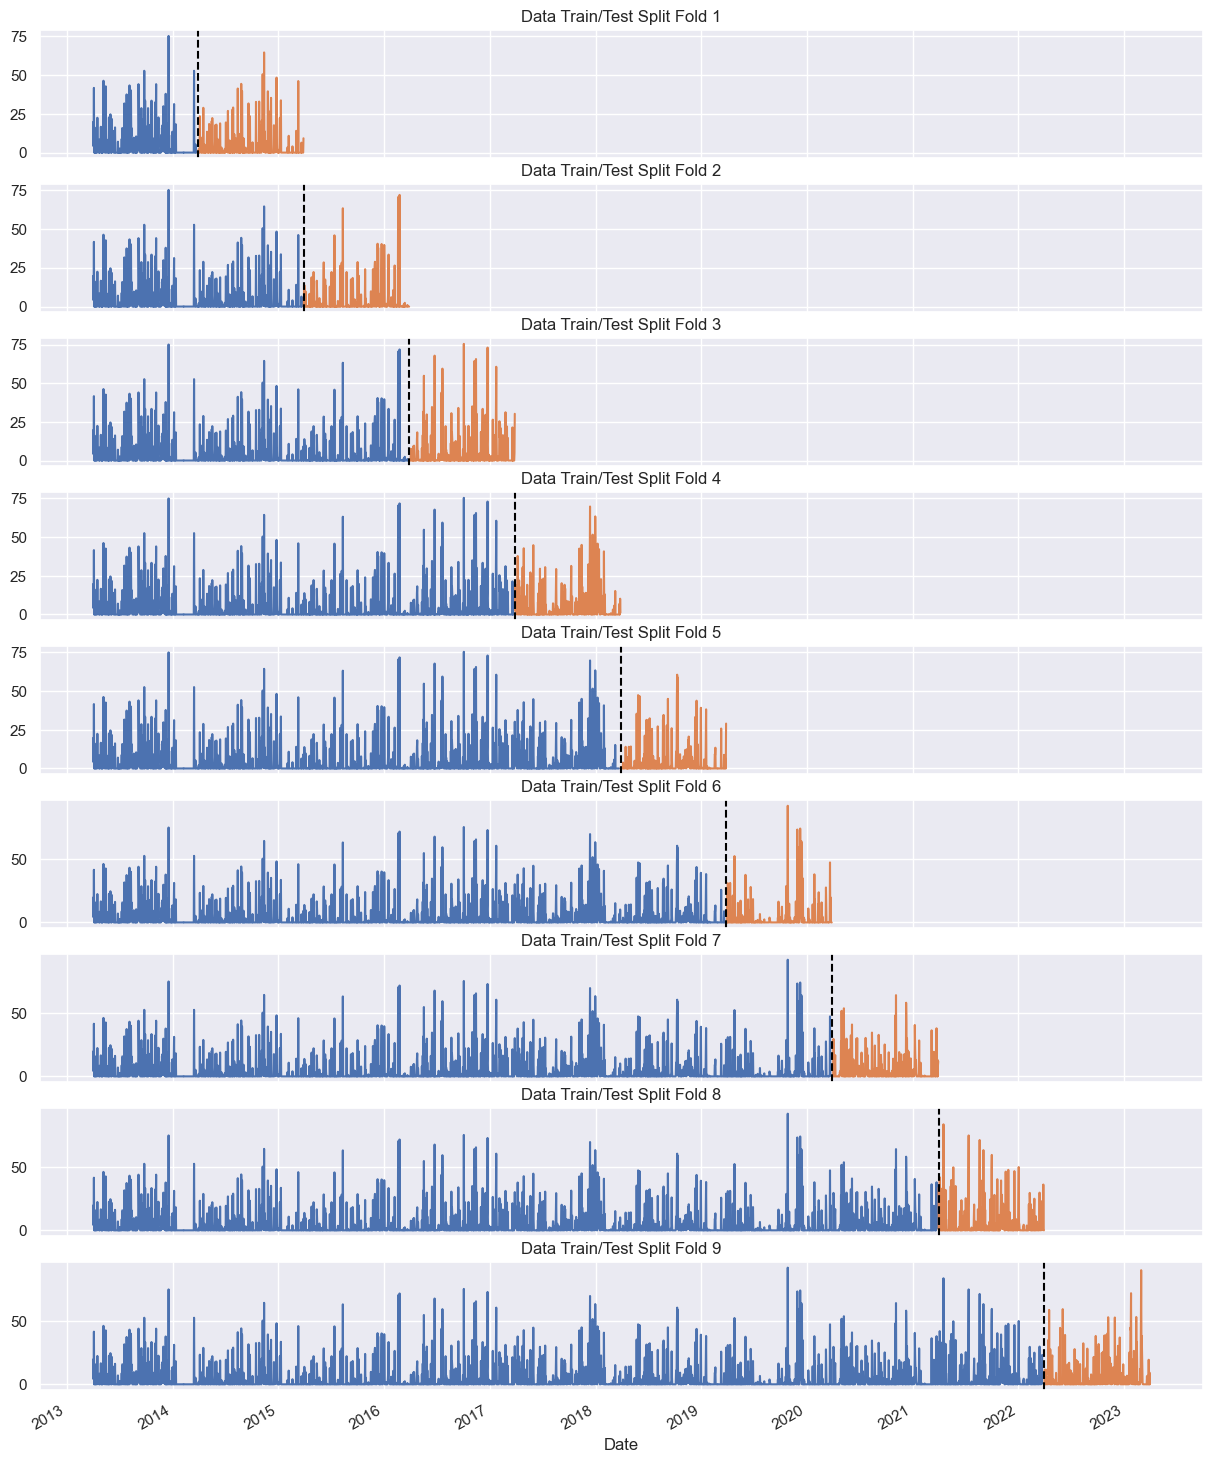

In [11]:
tss = TimeSeriesSplit(n_splits=9, test_size=365, gap=5)

train = rainData.loc[rainData.index < '2022-04-01']
test = rainData.loc[rainData.index >= '2022-04-01']

fig, axs = plt.subplots(9, 1, figsize=(15, 20), sharex=True)

fold = 0
for x, y in tss.split(rainData):
    train = rainData.iloc[x]
    test = rainData.iloc[y]
    train['Daily Rainfall Total (mm)'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold+1}')
    test['Daily Rainfall Total (mm)'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
   
plt.show()

# Choice of Machine Learning Model - XGBoost

Notice from our EDA that although our dataset contains a seasonal trend across each year, the pattern is not entirely consistent. For example, the rainfall is substantially low between Aug to Sep 2022 and high between Oct to Dec 2022, but high between Aug to Sep 2021 and slight lower in Oct to Dec 2021.

![Pattern](data/Pattern.jpg)

Due to these pattern discrepancies that have no linear relationship, we felt that Linear Regression may not give us a good prediction. Therefore, we've decided to employ eXtreme Gradient Boosting (or XGBoost) to tackle this problem. XGBoost uses multiple decision trees and gradient boosting to learn pattern differences in data, and is known to be effective when a dataset becomes complex or has nonlinear pattern. It also contains certain features that control overfitting of our data, to ensure that the performance between train and test set is consistent.

In our context, we'll be using XGBoost's XGBRegressor for our training.

In [12]:
# Function for training
def fold_training(lag, df_train, df_test):
    
    tss = TimeSeriesSplit(n_splits=9, test_size=365, gap=5)
    
    preds = []
    scores = []

    for x, y in tss.split(df_train):
        train = df_train.iloc[x]
        test = df_test.iloc[y]

        x_train = train[lag]
        y_train = train['Daily Rainfall Total (mm)']

        x_test = test[lag]
        y_test = test['Daily Rainfall Total (mm)']

        reg = xgb.XGBRegressor(n_estimators=1000, objective='reg:squarederror', max_depth=2, early_stopping_rounds=100)

        reg.fit(x_train, y_train, eval_set=[(x_train, y_train)], verbose=False)

        y_pred = reg.predict(x_test)
        preds.append(y_pred) 

        score = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
        scores.append(score)
    
    print(f'Score across folds {np.mean(scores):0.2f}')
    print(f'Fold scores:{scores}')
    
    return reg

# Function for forecasting
def rain_forecast(lag, train_set, reg, date_start, date_end):
    future = pd.date_range(date_start, date_end, freq='1d')
    forecast = pd.DataFrame(index=future)
    forecast['isFuture'] = True
    train_set['isFuture'] = False
    combined = pd.concat([train_set, forecast])
    combined['Day'] = combined.index.day
    combined['Month'] = combined.index.month
    combined['Year'] = combined.index.year

    combinedFuture = combined.query('isFuture').copy()
    combinedFuture['Predicted'] = reg.predict(combinedFuture[lag])
    
    return combinedFuture

The hyper-parameters in XGBRegressor are tuned with the consideration of 1) preventing over/underfitting and 2) large computational time. After several trials to observe the model's performance, we've decided that the following optimum tuning parameters for our prediction:

- n_estimators = 1000 (1000 boosting iterations/trees)
- max_depth = 2 (Each tree does not branch more than 2 times)
- early_stopping_rounds = 100 (Stops at 100 boosting rounds if RMSE does not improve)

We'll be using the RMSE from each prediction to assess our model's performance.

In [13]:
no_lag = ['Year','Month','Day']

# No Lag, No Smooth
reg_nlns = fold_training(no_lag, rainData, rainData)
print()

Score across folds 12.08
Fold scores:[11.15, 11.15, 13.09, 11.64, 11.57, 12.06, 11.15, 14.02, 12.85]



Trial across number of splits (n):

(4)
- Score across folds 12.52
- Fold scores:[12.06, 11.15, 14.02, 12.85]

(5)
- Score across folds 12.33
- Fold scores:[11.57, 12.06, 11.15, 14.02, 12.85]

(6)
- Score across folds 12.21
- Fold scores:[11.64, 11.57, 12.06, 11.15, 14.02, 12.85]

(7)
- Score across folds 12.34
- Fold scores:[13.09, 11.64, 11.57, 12.06, 11.15, 14.02, 12.85]

(8)
- Score across folds 12.19
- Fold scores:[11.15, 13.09, 11.64, 11.57, 12.06, 11.15, 14.02, 12.85]

(9)
- Score across folds 12.08
- Fold scores:[11.15, 11.15, 13.09, 11.64, 11.57, 12.06, 11.15, 14.02, 12.85]



From the train/test split and the EDA section earlier, we saw that our dataset is noisy due to daily rainfall fluctuations and does not carry any meanings to our prediction. Let's smooth out this noise by doing a moving average of our train data and see how our model performs throughout the training and prediction. 

We will try averaging over windows of 7, 15 and 30 days to see which window gives us the best performance. (As we are studying seasonal trend across different months, averaging beyond 30 days will change the seasonal trend of our dataset)

(Caution: As we are evaluating our test data's performance, we must use actual data for the test set and not smooth them out. Otherwise we would be deceiving ourselves with the results.)

# Smooth Train Set VS Test Set (A 30 Day Window Sample)
This is how our smoothed train set will look like against our test set in our machine learning. A shorter smoothing window will result in a more erratic train set graph.

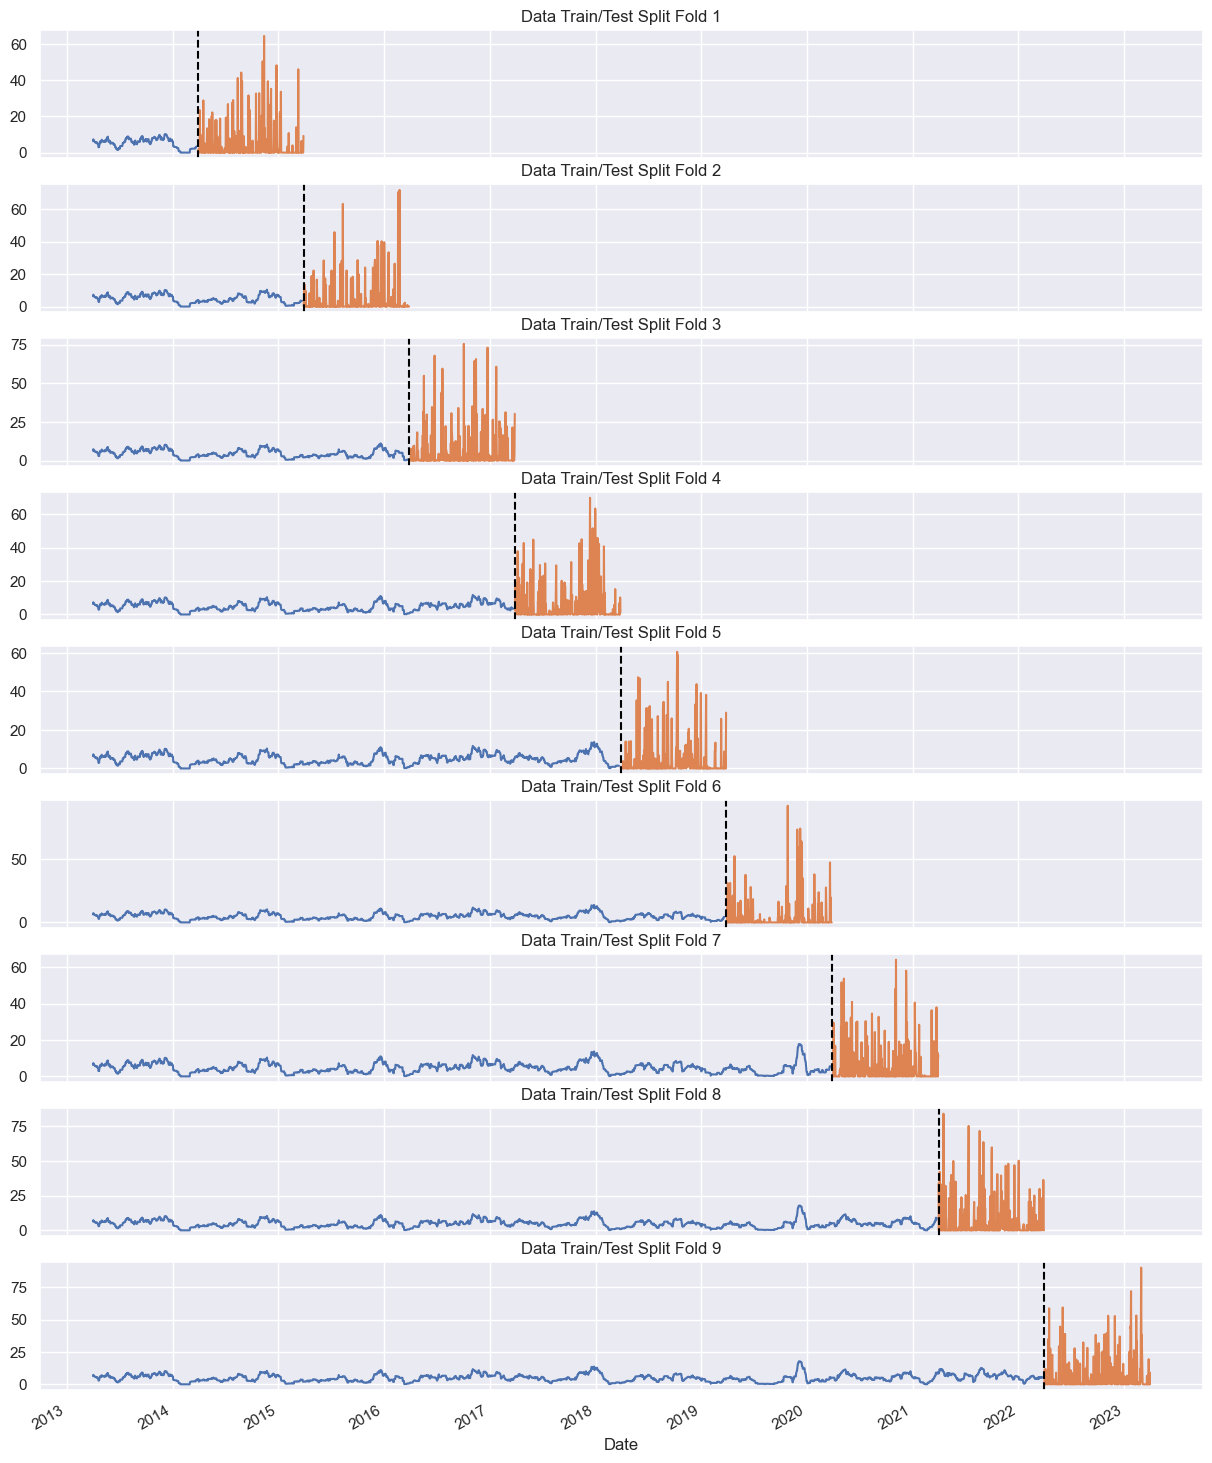

In [14]:
mov_7 = rainData.rolling(window=7, center=True, min_periods=3).mean()
mov_7 = mov_7.sort_index()

mov_15 = rainData.rolling(window=15, center=True, min_periods=7).mean()
mov_15 = mov_15.sort_index()

mov_30 = rainData.rolling(window=30, center=True, min_periods=15).mean()
mov_30 = mov_30.sort_index()

tss = TimeSeriesSplit(n_splits=9, test_size=365, gap=5)

train = rainData.loc[mov_30.index < '2022-04-01']
test = rainData.loc[rainData.index >= '2022-04-01']

fig, axs = plt.subplots(9, 1, figsize=(15, 20), sharex=True)

fold = 0
for x, y in tss.split(mov_30):
    train = mov_30.iloc[x]
    test = rainData.iloc[y]
    train['Daily Rainfall Total (mm)'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold+1}')
    test['Daily Rainfall Total (mm)'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
   
plt.show()

In [15]:
# No Lag, Smooth
print("No Lag features, Train Data Smoothed 7 days")
reg_nls7 = fold_training(no_lag, mov_7, rainData)
print()

print("No Lag features, Train Data Smoothed 15 days")
reg_nls15 = fold_training(no_lag, mov_15, rainData)
print()

print("No Lag features, Train Data Smoothed 30 days")
reg_nls30 = fold_training(no_lag, mov_30, rainData)
print()

No Lag features, Train Data Smoothed 7 days
Score across folds 11.82
Fold scores:[10.58, 10.42, 12.85, 10.98, 11.8, 12.09, 11.13, 13.65, 12.91]

No Lag features, Train Data Smoothed 15 days
Score across folds 11.50
Fold scores:[10.03, 10.27, 12.3, 10.87, 10.73, 12.03, 10.9, 13.59, 12.76]

No Lag features, Train Data Smoothed 30 days
Score across folds 11.35
Fold scores:[9.83, 10.3, 12.23, 10.32, 10.07, 12.05, 11.04, 13.66, 12.69]



Smoothing our train dataset seemed to improved our model's performance. Let's look at our rainfall prediction 1 year ahead for both the unsmoothed and smoothed sets, and observe if their trends are anything close to the annual trend seen in our EDA.

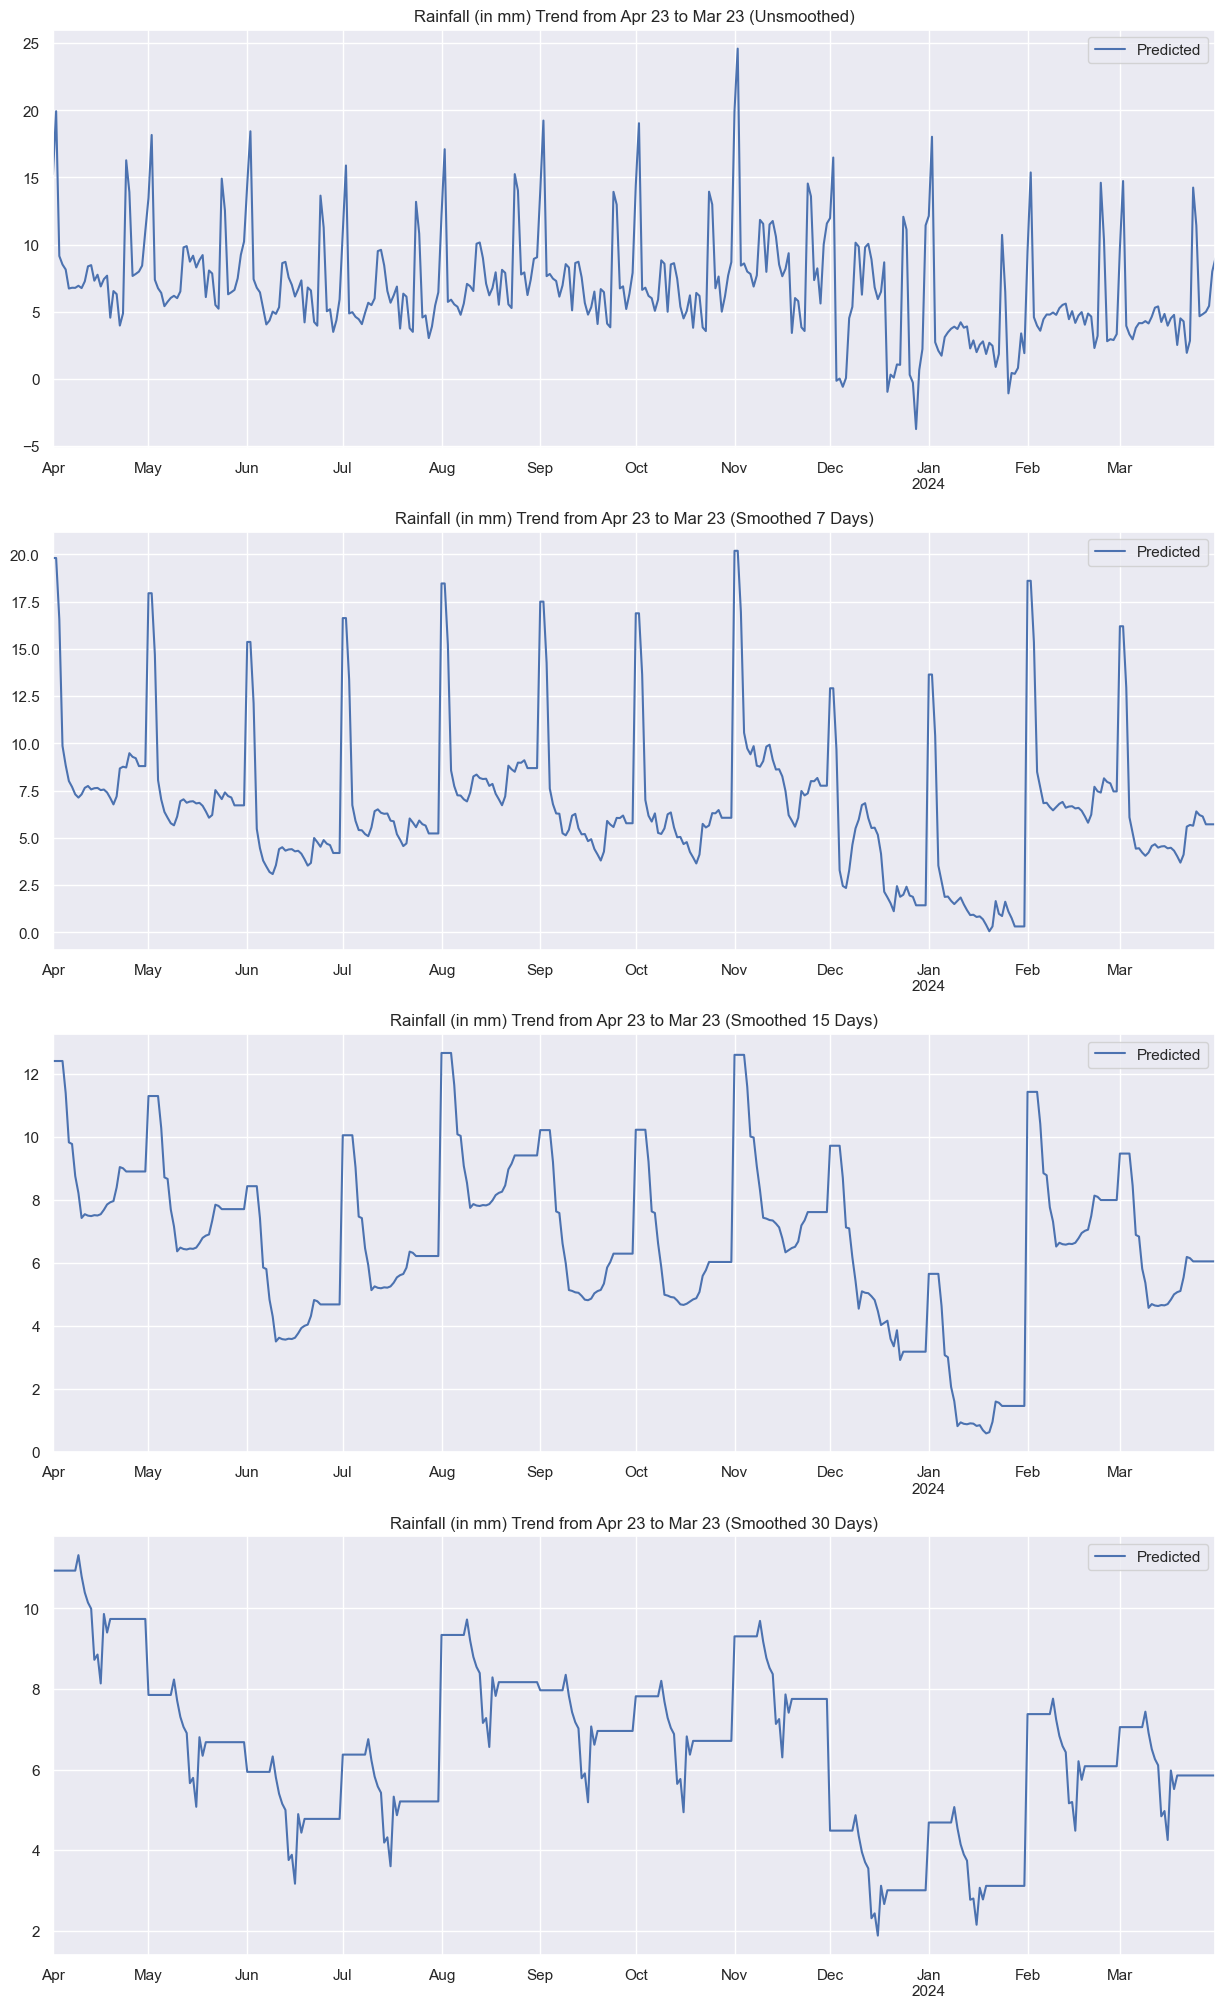

In [16]:
combinedFuture1 = rain_forecast(no_lag, rainData, reg_nlns, '2023-04-01', '2024-03-31')
combinedFuture1s7 = rain_forecast(no_lag, mov_7, reg_nls7, '2023-04-01', '2024-03-31')
combinedFuture1s15 = rain_forecast(no_lag, mov_15, reg_nls15, '2023-04-01', '2024-03-31')
combinedFuture1s30 = rain_forecast(no_lag, mov_30, reg_nls30, '2023-04-01', '2024-03-31')

f, axes = plt.subplots(4, 1, figsize=(15, 25))
combinedFuture1.plot(ax=axes[0], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Unsmoothed)')
combinedFuture1s7.plot(ax=axes[1], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 7 Days)')
combinedFuture1s15.plot(ax=axes[2], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 15 Days)')
combinedFuture1s30.plot(ax=axes[3], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 30 Days)')
plt.show()

Notice from all graphs that we did not get the seasonal trend close to the one from our EDA. In fact, their patterns are erratic (Less erratic as smoothing window increases).

# Adding Lag Features

As our rainfall data contains an annual trend, we'll need past values of the same period of prediction (known as lagged features) from our data for the model to capture this seasonal pattern and accurately predict future rainfall.

We've created the lag features required subsequently in the add_lags() function.

In [18]:
# For adding lagged features
def add_lags(df):
    # Time
    rain_lag = df['Daily Rainfall Total (mm)'].to_dict()
    df['D-1_rain'] = (df.index - pd.Timedelta(days=1)).map(rain_lag)
    df['D-2_rain'] = (df.index - pd.Timedelta(days=2)).map(rain_lag)
    df['D-3_rain'] = (df.index - pd.Timedelta(days=3)).map(rain_lag)
    df['D-4_rain'] = (df.index - pd.Timedelta(days=4)).map(rain_lag)
    df['D-5_rain'] = (df.index - pd.Timedelta(days=5)).map(rain_lag)
    df['D-6_rain'] = (df.index - pd.Timedelta(days=6)).map(rain_lag)
    df['D-7_rain'] = (df.index - pd.Timedelta(days=7)).map(rain_lag)
    df['D-8_rain'] = (df.index - pd.Timedelta(days=8)).map(rain_lag)
    df['D-9_rain'] = (df.index - pd.Timedelta(days=9)).map(rain_lag)
    df['D-10_rain'] = (df.index - pd.Timedelta(days=10)).map(rain_lag)
    df['D-11_rain'] = (df.index - pd.Timedelta(days=11)).map(rain_lag)
    df['D-12_rain'] = (df.index - pd.Timedelta(days=12)).map(rain_lag)
    df['D-13_rain'] = (df.index - pd.Timedelta(days=13)).map(rain_lag)
    df['D-14_rain'] = (df.index - pd.Timedelta(days=14)).map(rain_lag)
    df['D-15_rain'] = (df.index - pd.Timedelta(days=15)).map(rain_lag)
    df['D-16_rain'] = (df.index - pd.Timedelta(days=16)).map(rain_lag)
    df['D-17_rain'] = (df.index - pd.Timedelta(days=17)).map(rain_lag)
    df['D-18_rain'] = (df.index - pd.Timedelta(days=18)).map(rain_lag)
    df['D-19_rain'] = (df.index - pd.Timedelta(days=19)).map(rain_lag)
    df['D-20_rain'] = (df.index - pd.Timedelta(days=20)).map(rain_lag)
    df['D-21_rain'] = (df.index - pd.Timedelta(days=21)).map(rain_lag)
    df['D-22_rain'] = (df.index - pd.Timedelta(days=22)).map(rain_lag)
    df['D-23_rain'] = (df.index - pd.Timedelta(days=23)).map(rain_lag)
    df['D-24_rain'] = (df.index - pd.Timedelta(days=24)).map(rain_lag)
    df['D-25_rain'] = (df.index - pd.Timedelta(days=25)).map(rain_lag)
    df['D-26_rain'] = (df.index - pd.Timedelta(days=26)).map(rain_lag)
    df['D-27_rain'] = (df.index - pd.Timedelta(days=27)).map(rain_lag)
    df['D-28_rain'] = (df.index - pd.Timedelta(days=28)).map(rain_lag)
    
    df['M-1_rain'] = (df.index - pd.Timedelta(days=30)).map(rain_lag)
    df['M-2_rain'] = (df.index - pd.Timedelta(days=60)).map(rain_lag)
    df['M-3_rain'] = (df.index - pd.Timedelta(days=90)).map(rain_lag)
    df['M-4_rain'] = (df.index - pd.Timedelta(days=120)).map(rain_lag)
    df['M-5_rain'] = (df.index - pd.Timedelta(days=150)).map(rain_lag)
    df['M-6_rain'] = (df.index - pd.Timedelta(days=180)).map(rain_lag)
    df['M-7_rain'] = (df.index - pd.Timedelta(days=210)).map(rain_lag)
    df['M-8_rain'] = (df.index - pd.Timedelta(days=240)).map(rain_lag)
    df['M-9_rain'] = (df.index - pd.Timedelta(days=270)).map(rain_lag)
    df['M-10_rain'] = (df.index - pd.Timedelta(days=300)).map(rain_lag)
    df['M-11_rain'] = (df.index - pd.Timedelta(days=330)).map(rain_lag)
    df['M-12_rain'] = (df.index - pd.Timedelta(days=360)).map(rain_lag)
    
    df['Y-1_rain'] = (df.index - pd.Timedelta(days=365)).map(rain_lag)
    df['Y-2_rain'] = (df.index - pd.Timedelta(days=730)).map(rain_lag)
    df['Y-3_rain'] = (df.index - pd.Timedelta(days=1095)).map(rain_lag)
    df['Y-4_rain'] = (df.index - pd.Timedelta(days=1460)).map(rain_lag)
    df['Y-5_rain'] = (df.index - pd.Timedelta(days=1825)).map(rain_lag)
    df['Y-6_rain'] = (df.index - pd.Timedelta(days=2190)).map(rain_lag)
    df['Y-7_rain'] = (df.index - pd.Timedelta(days=2555)).map(rain_lag)
    
    # Temperature
    temp_lag = df['Mean Temperature (°C)'].to_dict()
    df['D-1_temp'] = (df.index - pd.Timedelta(days=1)).map(temp_lag)
    df['D-2_temp'] = (df.index - pd.Timedelta(days=2)).map(temp_lag)
    df['D-3_temp'] = (df.index - pd.Timedelta(days=3)).map(temp_lag)
    df['D-4_temp'] = (df.index - pd.Timedelta(days=4)).map(temp_lag)
    df['D-5_temp'] = (df.index - pd.Timedelta(days=5)).map(temp_lag)
    df['D-6_temp'] = (df.index - pd.Timedelta(days=6)).map(temp_lag)
    df['D-7_temp'] = (df.index - pd.Timedelta(days=7)).map(temp_lag)
    df['D-8_temp'] = (df.index - pd.Timedelta(days=8)).map(temp_lag)
    df['D-9_temp'] = (df.index - pd.Timedelta(days=9)).map(temp_lag)
    df['D-10_temp'] = (df.index - pd.Timedelta(days=10)).map(temp_lag)
    df['D-11_temp'] = (df.index - pd.Timedelta(days=11)).map(temp_lag)
    df['D-12_temp'] = (df.index - pd.Timedelta(days=12)).map(temp_lag)
    df['D-13_temp'] = (df.index - pd.Timedelta(days=13)).map(temp_lag)
    df['D-14_temp'] = (df.index - pd.Timedelta(days=14)).map(temp_lag)
    df['D-15_temp'] = (df.index - pd.Timedelta(days=15)).map(temp_lag)
    df['D-16_temp'] = (df.index - pd.Timedelta(days=16)).map(temp_lag)
    df['D-17_temp'] = (df.index - pd.Timedelta(days=17)).map(temp_lag)
    df['D-18_temp'] = (df.index - pd.Timedelta(days=18)).map(temp_lag)
    df['D-19_temp'] = (df.index - pd.Timedelta(days=19)).map(temp_lag)
    df['D-20_temp'] = (df.index - pd.Timedelta(days=20)).map(temp_lag)
    df['D-21_temp'] = (df.index - pd.Timedelta(days=21)).map(temp_lag)
    df['D-22_temp'] = (df.index - pd.Timedelta(days=22)).map(temp_lag)
    df['D-23_temp'] = (df.index - pd.Timedelta(days=23)).map(temp_lag)
    df['D-24_temp'] = (df.index - pd.Timedelta(days=24)).map(temp_lag)
    df['D-25_temp'] = (df.index - pd.Timedelta(days=25)).map(temp_lag)
    df['D-26_temp'] = (df.index - pd.Timedelta(days=26)).map(temp_lag)
    df['D-27_temp'] = (df.index - pd.Timedelta(days=27)).map(temp_lag)
    df['D-28_temp'] = (df.index - pd.Timedelta(days=28)).map(temp_lag)
    
    df['M-1_temp'] = (df.index - pd.Timedelta(days=30)).map(temp_lag)
    df['M-2_temp'] = (df.index - pd.Timedelta(days=60)).map(temp_lag)
    df['M-3_temp'] = (df.index - pd.Timedelta(days=90)).map(temp_lag)
    df['M-4_temp'] = (df.index - pd.Timedelta(days=120)).map(temp_lag)
    df['M-5_temp'] = (df.index - pd.Timedelta(days=150)).map(temp_lag)
    df['M-6_temp'] = (df.index - pd.Timedelta(days=180)).map(temp_lag)
    df['M-7_temp'] = (df.index - pd.Timedelta(days=210)).map(temp_lag)
    df['M-8_temp'] = (df.index - pd.Timedelta(days=240)).map(temp_lag)
    df['M-9_temp'] = (df.index - pd.Timedelta(days=270)).map(temp_lag)
    df['M-10_temp'] = (df.index - pd.Timedelta(days=300)).map(temp_lag)
    df['M-11_temp'] = (df.index - pd.Timedelta(days=330)).map(temp_lag)
    df['M-12_temp'] = (df.index - pd.Timedelta(days=360)).map(temp_lag)
    
    df['Y-1_temp'] = (df.index - pd.Timedelta(days=365)).map(temp_lag)
    df['Y-2_temp'] = (df.index - pd.Timedelta(days=730)).map(temp_lag)
    df['Y-3_temp'] = (df.index - pd.Timedelta(days=1095)).map(temp_lag)
    df['Y-4_temp'] = (df.index - pd.Timedelta(days=1460)).map(temp_lag)
    df['Y-5_temp'] = (df.index - pd.Timedelta(days=1825)).map(temp_lag)
    df['Y-6_temp'] = (df.index - pd.Timedelta(days=2190)).map(temp_lag)
    df['Y-7_temp'] = (df.index - pd.Timedelta(days=2555)).map(temp_lag)
    
    # Humidity
    hum_lag = df['Mean Humidity (%)'].to_dict()
    df['D-1_hum'] = (df.index - pd.Timedelta(days=1)).map(hum_lag)
    df['D-2_hum'] = (df.index - pd.Timedelta(days=2)).map(hum_lag)
    df['D-3_hum'] = (df.index - pd.Timedelta(days=3)).map(hum_lag)
    df['D-4_hum'] = (df.index - pd.Timedelta(days=4)).map(hum_lag)
    df['D-5_hum'] = (df.index - pd.Timedelta(days=5)).map(hum_lag)
    df['D-6_hum'] = (df.index - pd.Timedelta(days=6)).map(hum_lag)
    df['D-7_hum'] = (df.index - pd.Timedelta(days=7)).map(hum_lag)
    df['D-8_hum'] = (df.index - pd.Timedelta(days=8)).map(hum_lag)
    df['D-9_hum'] = (df.index - pd.Timedelta(days=9)).map(hum_lag)
    df['D-10_hum'] = (df.index - pd.Timedelta(days=10)).map(hum_lag)
    df['D-11_hum'] = (df.index - pd.Timedelta(days=11)).map(hum_lag)
    df['D-12_hum'] = (df.index - pd.Timedelta(days=12)).map(hum_lag)
    df['D-13_hum'] = (df.index - pd.Timedelta(days=13)).map(hum_lag)
    df['D-14_hum'] = (df.index - pd.Timedelta(days=14)).map(hum_lag)
    df['D-15_hum'] = (df.index - pd.Timedelta(days=15)).map(hum_lag)
    df['D-16_hum'] = (df.index - pd.Timedelta(days=16)).map(hum_lag)
    df['D-17_hum'] = (df.index - pd.Timedelta(days=17)).map(hum_lag)
    df['D-18_hum'] = (df.index - pd.Timedelta(days=18)).map(hum_lag)
    df['D-19_hum'] = (df.index - pd.Timedelta(days=19)).map(hum_lag)
    df['D-20_hum'] = (df.index - pd.Timedelta(days=20)).map(hum_lag)
    df['D-21_hum'] = (df.index - pd.Timedelta(days=21)).map(hum_lag)
    df['D-22_hum'] = (df.index - pd.Timedelta(days=22)).map(hum_lag)
    df['D-23_hum'] = (df.index - pd.Timedelta(days=23)).map(hum_lag)
    df['D-24_hum'] = (df.index - pd.Timedelta(days=24)).map(hum_lag)
    df['D-25_hum'] = (df.index - pd.Timedelta(days=25)).map(hum_lag)
    df['D-26_hum'] = (df.index - pd.Timedelta(days=26)).map(hum_lag)
    df['D-27_hum'] = (df.index - pd.Timedelta(days=27)).map(hum_lag)
    df['D-28_hum'] = (df.index - pd.Timedelta(days=28)).map(hum_lag)
    
    df['M-1_hum'] = (df.index - pd.Timedelta(days=30)).map(hum_lag)
    df['M-2_hum'] = (df.index - pd.Timedelta(days=60)).map(hum_lag)
    df['M-3_hum'] = (df.index - pd.Timedelta(days=90)).map(hum_lag)
    df['M-4_hum'] = (df.index - pd.Timedelta(days=120)).map(hum_lag)
    df['M-5_hum'] = (df.index - pd.Timedelta(days=150)).map(hum_lag)
    df['M-6_hum'] = (df.index - pd.Timedelta(days=180)).map(hum_lag)
    df['M-7_hum'] = (df.index - pd.Timedelta(days=210)).map(hum_lag)
    df['M-8_hum'] = (df.index - pd.Timedelta(days=240)).map(hum_lag)
    df['M-9_hum'] = (df.index - pd.Timedelta(days=270)).map(hum_lag)
    df['M-10_hum'] = (df.index - pd.Timedelta(days=300)).map(hum_lag)
    df['M-11_hum'] = (df.index - pd.Timedelta(days=330)).map(hum_lag)
    df['M-12_hum'] = (df.index - pd.Timedelta(days=360)).map(hum_lag)
    
    df['Y-1_hum'] = (df.index - pd.Timedelta(days=365)).map(hum_lag)
    df['Y-2_hum'] = (df.index - pd.Timedelta(days=730)).map(hum_lag)
    df['Y-3_hum'] = (df.index - pd.Timedelta(days=1095)).map(hum_lag)
    df['Y-4_hum'] = (df.index - pd.Timedelta(days=1460)).map(hum_lag)
    df['Y-5_hum'] = (df.index - pd.Timedelta(days=1825)).map(hum_lag)
    df['Y-6_hum'] = (df.index - pd.Timedelta(days=2190)).map(hum_lag)
    df['Y-7_hum'] = (df.index - pd.Timedelta(days=2555)).map(hum_lag)

    return df

rainData = add_lags(rainData)
mov_7 = add_lags(mov_7)
mov_15 = add_lags(mov_15)
mov_30 = add_lags(mov_30)

In [19]:
mov_30.drop(columns={'Year','Month','Day'}).tail()

,Daily Rainfall Total (mm),Mean Temperature (°C),Mean Humidity (%),isFuture,D-1_rain,D-2_rain,D-3_rain,D-4_rain,D-5_rain,D-6_rain,...,M-10_hum,M-11_hum,M-12_hum,Y-1_hum,Y-2_hum,Y-3_hum,Y-4_hum,Y-5_hum,Y-6_hum,Y-7_hum
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-27,2.400000,27.720000,81.585000,False,2.285714,2.181818,2.086957,2.000000,1.928000,1.861538,...,79.836667,80.923333,81.436667,81.203333,81.783333,76.356667,74.956667,77.940000,82.843333,74.843333
2023-03-28,2.526316,27.726316,81.615789,False,2.400000,2.285714,2.181818,2.086957,2.000000,1.928000,...,79.880000,80.960000,81.280000,81.496667,81.583333,76.446667,75.063333,77.830000,82.913333,74.793333
2023-03-29,2.666667,27.755556,81.811111,False,2.526316,2.400000,2.285714,2.181818,2.086957,2.000000,...,80.176667,80.840000,81.220000,81.473333,81.590000,76.596667,75.236667,77.856667,83.010000,74.706667
2023-03-30,2.823529,27.805882,81.988235,False,2.666667,2.526316,2.400000,2.285714,2.181818,2.086957,...,80.293333,80.616667,81.316667,81.610000,81.443333,76.620000,75.676667,77.966667,83.303333,74.790000
2023-03-31,3.000000,27.850000,82.193750,False,2.823529,2.666667,2.526316,2.400000,2.285714,2.181818,...,80.306667,80.486667,81.513333,81.336667,81.353333,76.450000,75.930000,78.233333,83.306667,75.030000


Let's begin by using Time as our lag features. We'll start with values from the past 3, 7, 14 and 28 days and see which amount of days give us the best RMSE. We'll also do versions of 1) unsmoothed, 2) 7 day smoothing, 3) 15 day smoothing and 4) 30 day smoothing of the trained dataset and monitor the model's performance of each version.

In [20]:
# NOTE: This may take a while to run completely. Enjoy Some PC Fan Wind #
lagD3 = no_lag + ['D-1_rain','D-2_rain','D-3_rain']

lagD7 = lagD3 + ['D-4_rain','D-5_rain','D-6_rain','D-7_rain']

lagD14 = lagD7 + ['D-8_rain','D-9_rain','D-10_rain','D-11_rain','D-12_rain','D-13_rain','D-14_rain']

lagD28 = lagD14 + ['D-15_rain','D-16_rain','D-17_rain','D-18_rain','D-19_rain','D-20_rain','D-21_rain',
                   'D-22_rain','D-23_rain','D-24_rain','D-25_rain','D-26_rain','D-27_rain','D-28_rain']

print("D-3, Unsmoothed")
reg_d3ns = fold_training(lagD3, rainData, rainData)
print()

print("D-3, Smoothed 7 days")
reg_d3s7 = fold_training(lagD3, mov_7, rainData)
print()

print("D-3, Smoothed 15 days")
reg_d3s15 = fold_training(lagD3, mov_15, rainData)
print()

print("D-3, Smoothed 30 days")
reg_d3s30 = fold_training(lagD3, mov_30, rainData)
print()

print("D-7, Unsmoothed")
reg_d7ns = fold_training(lagD7, rainData, rainData)
print()

print("D-7, Smoothed 7 days")
reg_d7s7 = fold_training(lagD7, mov_7, rainData)
print()

print("D-7, Smoothed 15 days")
reg_d7s15 = fold_training(lagD7, mov_15, rainData)
print()

print("D-7, Smoothed 30 days")
reg_d7s30 = fold_training(lagD7, mov_30, rainData)
print()

print("D-14, Unsmoothed")
reg_d14ns = fold_training(lagD14, rainData, rainData)
print()

print("D-14, Smoothed 7 days")
reg_d14s7 = fold_training(lagD14, mov_7, rainData)
print()

print("D-14, Smoothed 15 days")
reg_d14s15 = fold_training(lagD14, mov_15, rainData)
print()

print("D-14, Smoothed 30 days")
reg_d14s30 = fold_training(lagD14, mov_30, rainData)
print()

print("D-28, Unsmoothed")
reg_d28ns = fold_training(lagD28, rainData, rainData)
print()

print("D-28, Smoothed 7 days")
reg_d28s7 = fold_training(lagD28, mov_7, rainData)
print()

print("D-28, Smoothed 15 days")
reg_d28s15 = fold_training(lagD28, mov_15, rainData)
print()

print("D-28, Smoothed 30 days")
reg_d28s30 = fold_training(lagD28, mov_30, rainData)
print()

# NOTE: This may take a while to run completely. Enjoy Some PC Fan Wind #

D-3, Unsmoothed
Score across folds 12.87
Fold scores:[12.64, 11.18, 14.23, 12.4, 12.69, 12.85, 11.74, 14.61, 13.45]

D-3, Smoothed 7 days
Score across folds 12.31
Fold scores:[10.15, 10.63, 12.62, 11.58, 10.14, 12.34, 13.36, 15.29, 14.69]

D-3, Smoothed 15 days
Score across folds 11.70
Fold scores:[9.92, 10.17, 12.54, 10.86, 9.7, 11.81, 12.05, 14.56, 13.71]

D-3, Smoothed 30 days
Score across folds 11.27
Fold scores:[9.63, 9.86, 12.24, 10.52, 9.59, 11.56, 10.97, 13.76, 13.32]

D-7, Unsmoothed
Score across folds 13.03
Fold scores:[12.35, 11.77, 13.24, 13.42, 11.64, 13.69, 11.65, 15.79, 13.74]

D-7, Smoothed 7 days
Score across folds 13.39
Fold scores:[10.25, 10.57, 14.04, 12.0, 11.47, 12.64, 15.11, 17.28, 17.15]

D-7, Smoothed 15 days
Score across folds 11.71
Fold scores:[9.87, 10.27, 12.44, 10.88, 9.81, 11.9, 12.08, 14.53, 13.57]

D-7, Smoothed 30 days
Score across folds 11.45
Fold scores:[9.78, 9.95, 12.36, 10.72, 9.65, 11.69, 11.35, 13.91, 13.63]

D-14, Unsmoothed
Score across folds 

Seems like using values up to the past 3 days and a smoothing window of 30 days gave us the best result. Also note that the smooth versions of each lag feature outperformed their unsmooth counterpart. Let's see how our seasonal pattern look like.

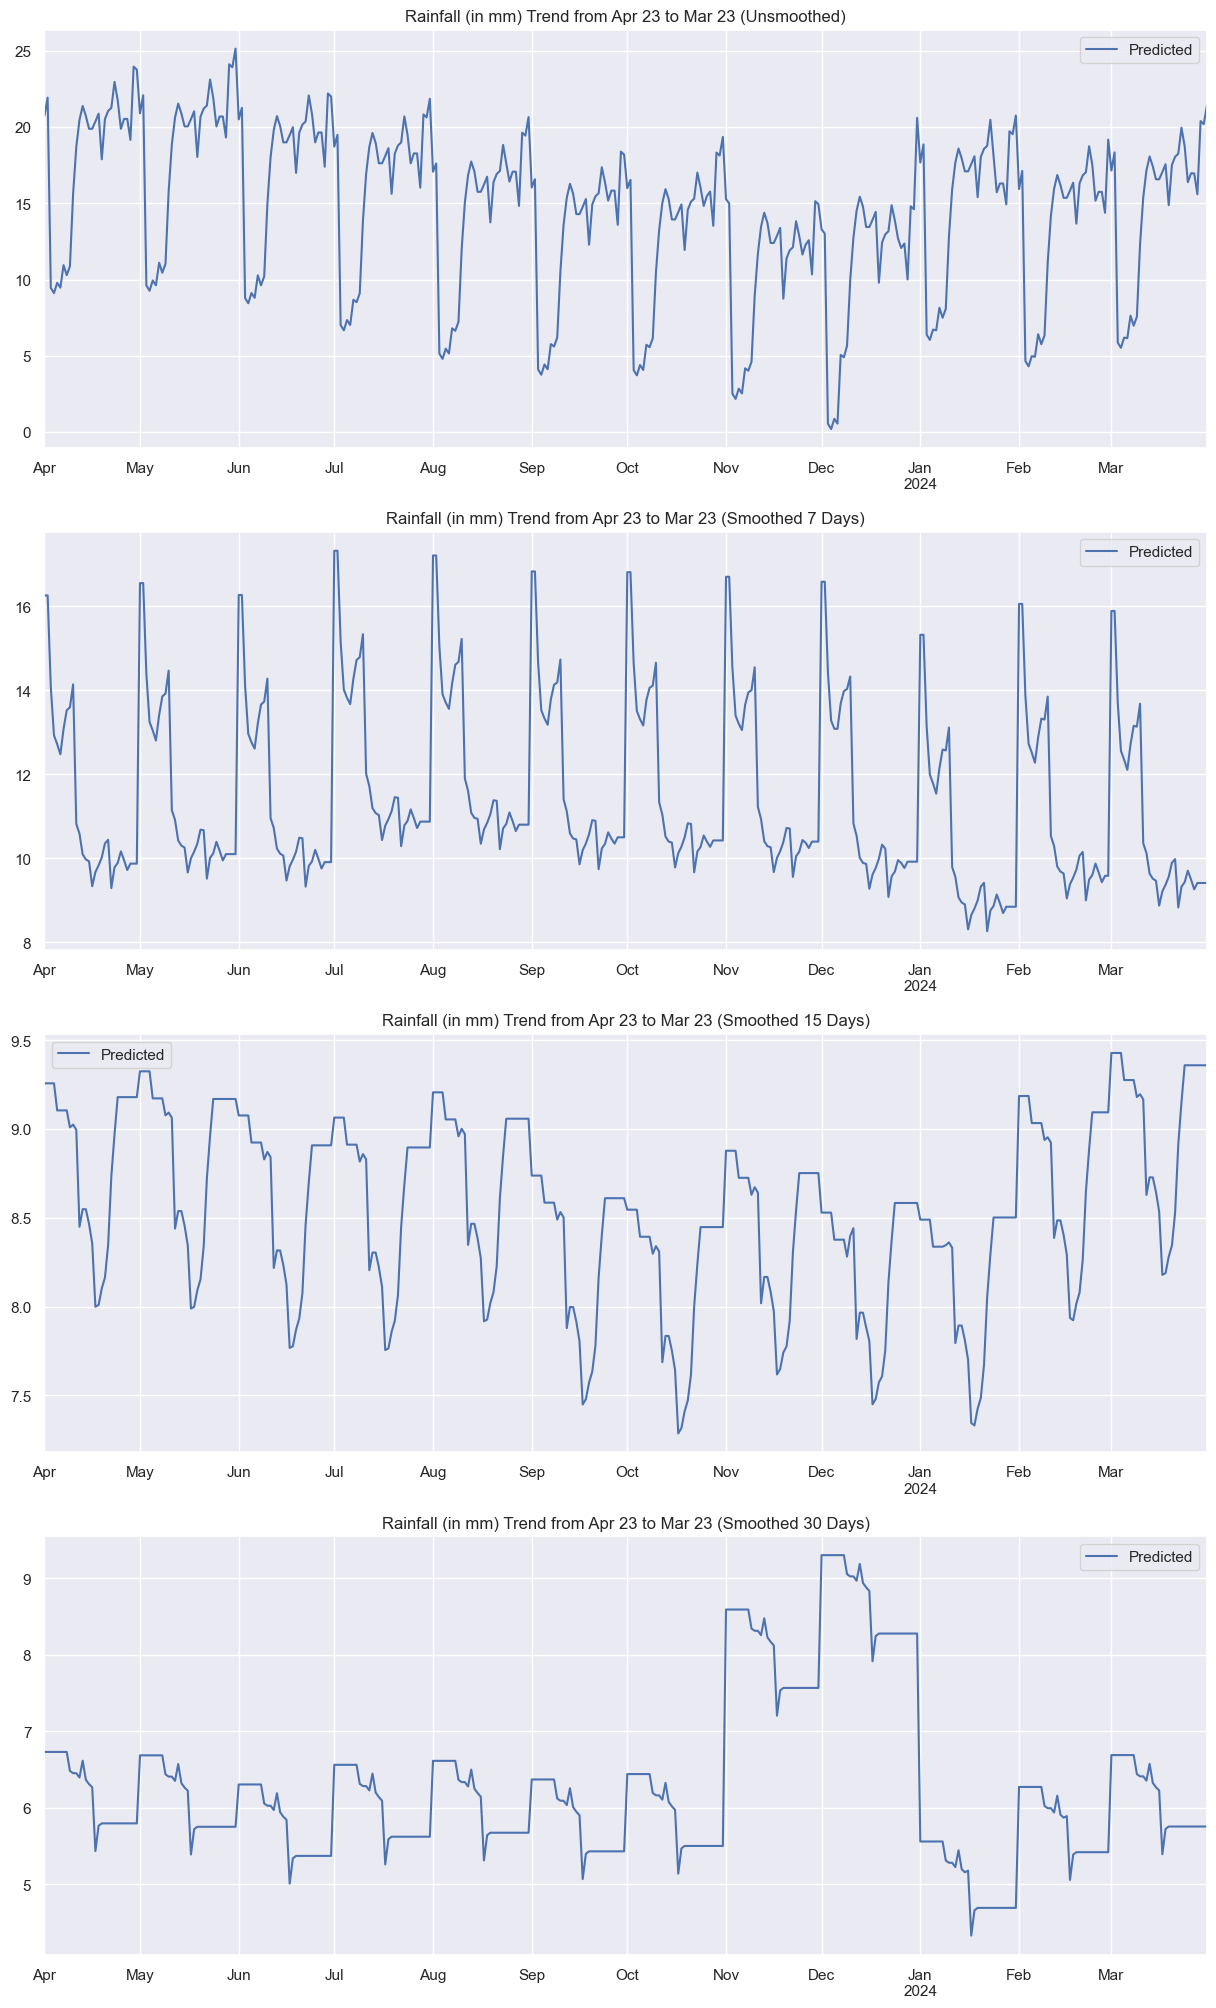

In [21]:
combinedFuture2 = rain_forecast(lagD3, rainData, reg_d3ns, '2023-04-01', '2024-03-31')
combinedFuture2s7 = rain_forecast(lagD3, mov_7, reg_d3s7, '2023-04-01', '2024-03-31')
combinedFuture2s15 = rain_forecast(lagD3, mov_15, reg_d3s15, '2023-04-01', '2024-03-31')
combinedFuture2s30 = rain_forecast(lagD3, mov_30, reg_d3s30, '2023-04-01', '2024-03-31')

f, axes = plt.subplots(4, 1, figsize=(15, 25))
combinedFuture2.plot(ax=axes[0], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Unsmoothed)')
combinedFuture2s7.plot(ax=axes[1], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 7 Days)')
combinedFuture2s15.plot(ax=axes[2], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 15 Days)')
combinedFuture2s30.plot(ax=axes[3], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 30 Days)')
plt.show()

The seasonal pattern of the 30 day graph seems to begin to look alike to that of our EDA, but the rest seem to have not improved.
Now we shall add values from the past 3, 6, 9 and 12 months to see if they improve our model's performance.

In [22]:
# NOTE: This may take a while to run completely. Enjoy Some PC Fan Wind #
lagM3 = lagD3 + ['M-1_rain','M-2_rain','M-3_rain']

lagM6 = lagM3 + ['M-4_rain','M-5_rain','M-6_rain']

lagM9 = lagM6 + ['M-7_rain','M-8_rain','M-9_rain']

lagM12 = lagM9 + ['M-10_rain','M-11_rain','M-12_rain']

print("M-3, Unsmoothed")
reg_m3ns = fold_training(lagM3, rainData, rainData)
print()

print("M-3, Smoothed 7 Days")
reg_m3s7 = fold_training(lagM3, mov_7, rainData)
print()

print("M-3, Smoothed 15 Days")
reg_m3s15 = fold_training(lagM3, mov_15, rainData)
print()

print("M-3, Smoothed 30 Days")
reg_m3s30 = fold_training(lagM3, mov_30, rainData)
print()

print("M-6, Unsmoothed")
reg_m6ns = fold_training(lagM6, rainData, rainData)
print()

print("M-6, Smoothed 7 Days")
reg_m6s7 = fold_training(lagM6, mov_7, rainData)
print()

print("M-6, Smoothed 15 Days")
reg_m6s15 = fold_training(lagM6, mov_15, rainData)
print()

print("M-6, Smoothed 30 Days")
reg_m6s30 = fold_training(lagM6, mov_30, rainData)
print()

print("M-9, Unsmoothed")
reg_m9ns = fold_training(lagM9, rainData, rainData)
print()

print("M-9, Smoothed 7 Days")
reg_m9s7 = fold_training(lagM9, mov_7, rainData)
print()

print("M-9, Smoothed 15 Days")
reg_m9s15 = fold_training(lagM9, mov_15, rainData)
print()

print("M-9, Smoothed 30 Days")
reg_m9s30 = fold_training(lagM9, mov_30, rainData)
print()

print("M-12, Unsmoothed")
reg_m12ns = fold_training(lagM12, rainData, rainData)
print()

print("M-12, Smoothed 7 Days")
reg_m12s7 = fold_training(lagM12, mov_7, rainData)
print()

print("M-12, Smoothed 15 Days")
reg_m12s15 = fold_training(lagM12, mov_15, rainData)
print()

print("M-12, Smoothed 30 Days")
reg_m12s30 = fold_training(lagM12, mov_30, rainData)
print()

# NOTE: This may take a while to run completely. Enjoy Some PC Fan Wind #

M-3, Unsmoothed
Score across folds 12.98
Fold scores:[12.5, 11.8, 15.3, 12.36, 11.87, 13.08, 12.26, 14.38, 13.29]

M-3, Smoothed 7 Days
Score across folds 12.24
Fold scores:[10.23, 10.3, 12.65, 11.35, 10.35, 12.28, 12.99, 15.17, 14.81]

M-3, Smoothed 15 Days
Score across folds 11.62
Fold scores:[9.93, 9.94, 12.61, 10.87, 9.76, 12.05, 11.69, 14.09, 13.63]

M-3, Smoothed 30 Days
Score across folds 11.21
Fold scores:[9.62, 9.82, 12.16, 10.52, 9.63, 11.41, 10.96, 13.58, 13.17]

M-6, Unsmoothed
Score across folds 13.01
Fold scores:[11.93, 11.89, 15.22, 13.14, 12.31, 13.38, 11.62, 14.45, 13.11]

M-6, Smoothed 7 Days
Score across folds 12.16
Fold scores:[10.47, 10.33, 12.45, 11.36, 10.12, 12.14, 12.77, 15.32, 14.49]

M-6, Smoothed 15 Days
Score across folds 11.58
Fold scores:[10.2, 9.75, 12.63, 10.83, 9.57, 11.85, 11.57, 14.04, 13.74]

M-6, Smoothed 30 Days
Score across folds 11.18
Fold scores:[9.72, 9.81, 12.08, 10.43, 9.62, 11.37, 10.91, 13.54, 13.13]

M-9, Unsmoothed
Score across folds 13.

Seems like using values up to the past 9 months and a smoothing window of 30 days improved our model (Notice that the RMSEs of M-9 and M-12 for 30 day smoothing are a tie, but we'll consider M-9 as the RMSE of M-9 in the unsmoothed set is better than that of M-12). Let's see how our annual trend looks like now.

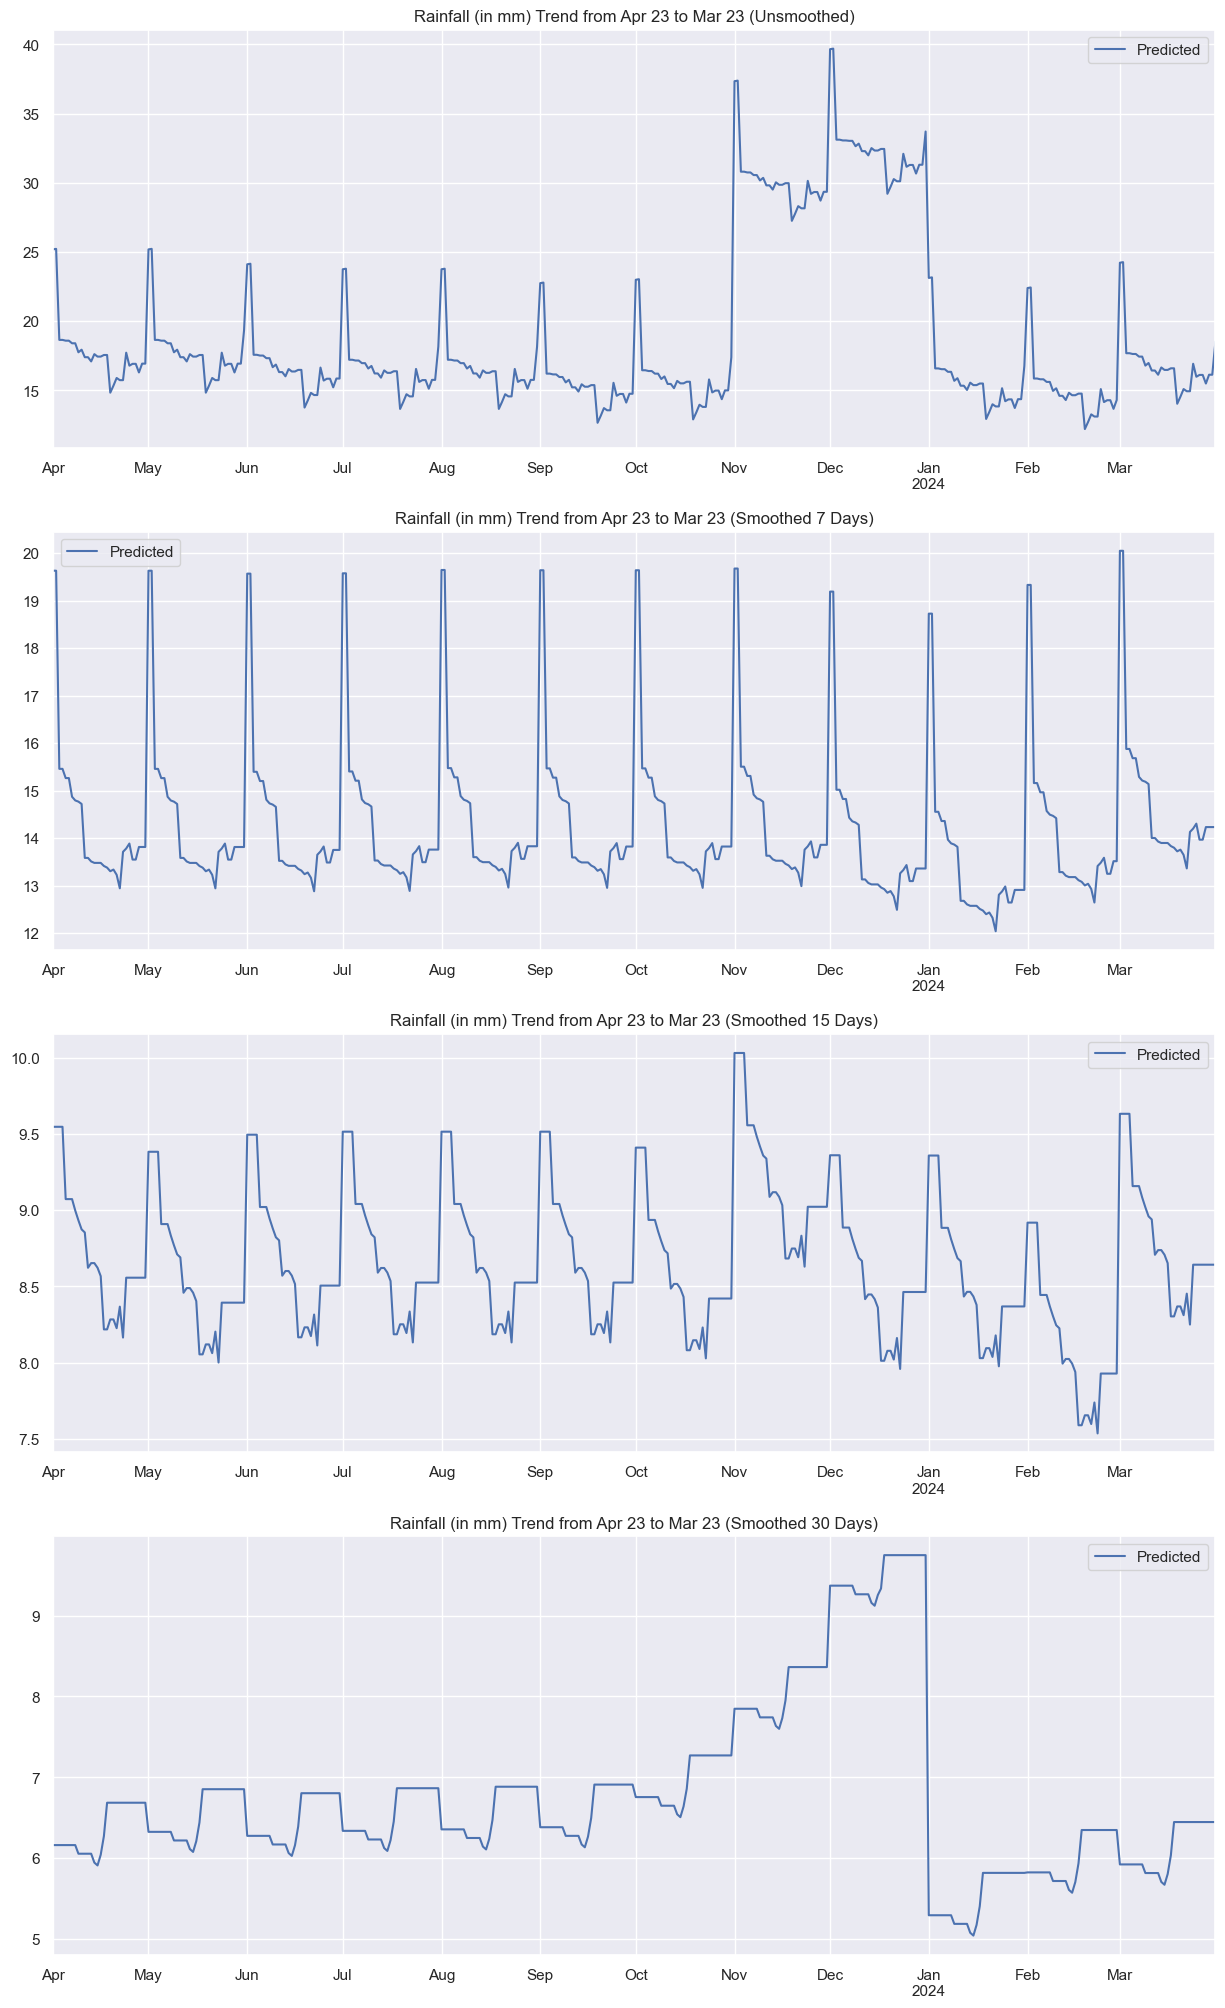

In [23]:
combinedFuture3 = rain_forecast(lagM9, rainData, reg_m9ns, '2023-04-01', '2024-03-31')
combinedFuture3s7 = rain_forecast(lagM9, mov_7, reg_m9s7, '2023-04-01', '2024-03-31')
combinedFuture3s15 = rain_forecast(lagM9, mov_15, reg_m9s15, '2023-04-01', '2024-03-31')
combinedFuture3s30 = rain_forecast(lagM9, mov_30, reg_m9s30, '2023-04-01', '2024-03-31')

f, axes = plt.subplots(4, 1, figsize=(15, 25))
combinedFuture3.plot(ax=axes[0], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Unsmoothed)')
combinedFuture3s7.plot(ax=axes[1], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 7 Days)')
combinedFuture3s15.plot(ax=axes[2], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 15 Days)')
combinedFuture3s30.plot(ax=axes[3], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 30 Days)')
plt.show()

The trend from the 30 day smoothed set seems to deviate slightly from that of D-3; It has a gradual increase of rainfall from Apr to Oct. The rest seem to have not improved.

We'll now add values from the past 3, 5, and 7 months to see how our model performs and hopefully by doing so, improve our graph's appearance.

In [24]:
# NOTE: This may take a while to run completely. Enjoy Some PC Fan Wind #
lagY3 = lagM9 + ['Y-1_rain','Y-2_rain','Y-3_rain']
lagY5 = lagY3 + ['Y-4_rain','Y-5_rain']
lagY7 = lagY5 + ['Y-6_rain','Y-7_rain']

print("Y-3, Unsmoothed")
reg_y3ns = fold_training(lagY3, rainData, rainData)
print()

print("Y-3, Smoothed 7 Days")
reg_y3s7 = fold_training(lagY3, mov_7, rainData)
print()

print("Y-3, Smoothed 15 Days")
reg_y3s15 = fold_training(lagY3, mov_15, rainData)
print()

print("Y-3, Smoothed 30 Days")
reg_y3s30 = fold_training(lagY3, mov_30, rainData)
print()

print("Y-5, Unsmoothed")
reg_y5ns = fold_training(lagY5, rainData, rainData)
print()

print("Y-5, Smoothed 7 Days")
reg_y5s7 = fold_training(lagY5, mov_7, rainData)
print()

print("Y-5, Smoothed 15 Days")
reg_y5s15 = fold_training(lagY5, mov_15, rainData)
print()

print("Y-5, Smoothed 30 Days")
reg_y5s30 = fold_training(lagY5, mov_30, rainData)
print()

print("Y-7, Unsmoothed")
reg_y7ns = fold_training(lagY7, rainData, rainData)
print()

print("Y-7, Smoothed 7 Days")
reg_y7s7 = fold_training(lagY7, mov_7, rainData)
print()

print("Y-7, Smoothed 15 Days")
reg_y7s15 = fold_training(lagY7, mov_15, rainData)
print()

print("Y-7, Smoothed 30 Days")
reg_y7s30 = fold_training(lagY7, mov_30, rainData)
print()
# NOTE: This may take a while to run completely. Enjoy Some PC Fan Wind #

Y-3, Unsmoothed
Score across folds 13.18
Fold scores:[12.07, 11.28, 15.32, 13.64, 12.37, 13.31, 12.32, 14.71, 13.59]

Y-3, Smoothed 7 Days
Score across folds 12.21
Fold scores:[10.97, 10.44, 12.98, 11.2, 10.03, 12.26, 12.51, 15.04, 14.47]

Y-3, Smoothed 15 Days
Score across folds 11.54
Fold scores:[10.19, 10.08, 12.41, 10.96, 9.61, 11.59, 11.58, 13.97, 13.49]

Y-3, Smoothed 30 Days
Score across folds 11.16
Fold scores:[9.73, 9.8, 12.16, 10.35, 9.58, 11.4, 10.99, 13.37, 13.02]

Y-5, Unsmoothed
Score across folds 13.17
Fold scores:[12.07, 11.28, 15.32, 13.64, 12.81, 13.45, 11.55, 14.92, 13.51]

Y-5, Smoothed 7 Days
Score across folds 12.19
Fold scores:[10.97, 10.44, 12.98, 11.2, 10.06, 12.2, 12.41, 15.25, 14.21]

Y-5, Smoothed 15 Days
Score across folds 11.50
Fold scores:[10.19, 10.08, 12.41, 10.96, 9.52, 11.66, 11.58, 13.78, 13.35]

Y-5, Smoothed 30 Days
Score across folds 11.16
Fold scores:[9.73, 9.8, 12.16, 10.35, 9.58, 11.37, 11.02, 13.34, 13.09]

Y-7, Unsmoothed
Score across folds 1

Now it seem like using values up to the past 7 years and a smoothing window of 30 days improved our performance further. Let's observe our 1 year prediction of all versions and see if we get anything closer to the seasonal pattern. 

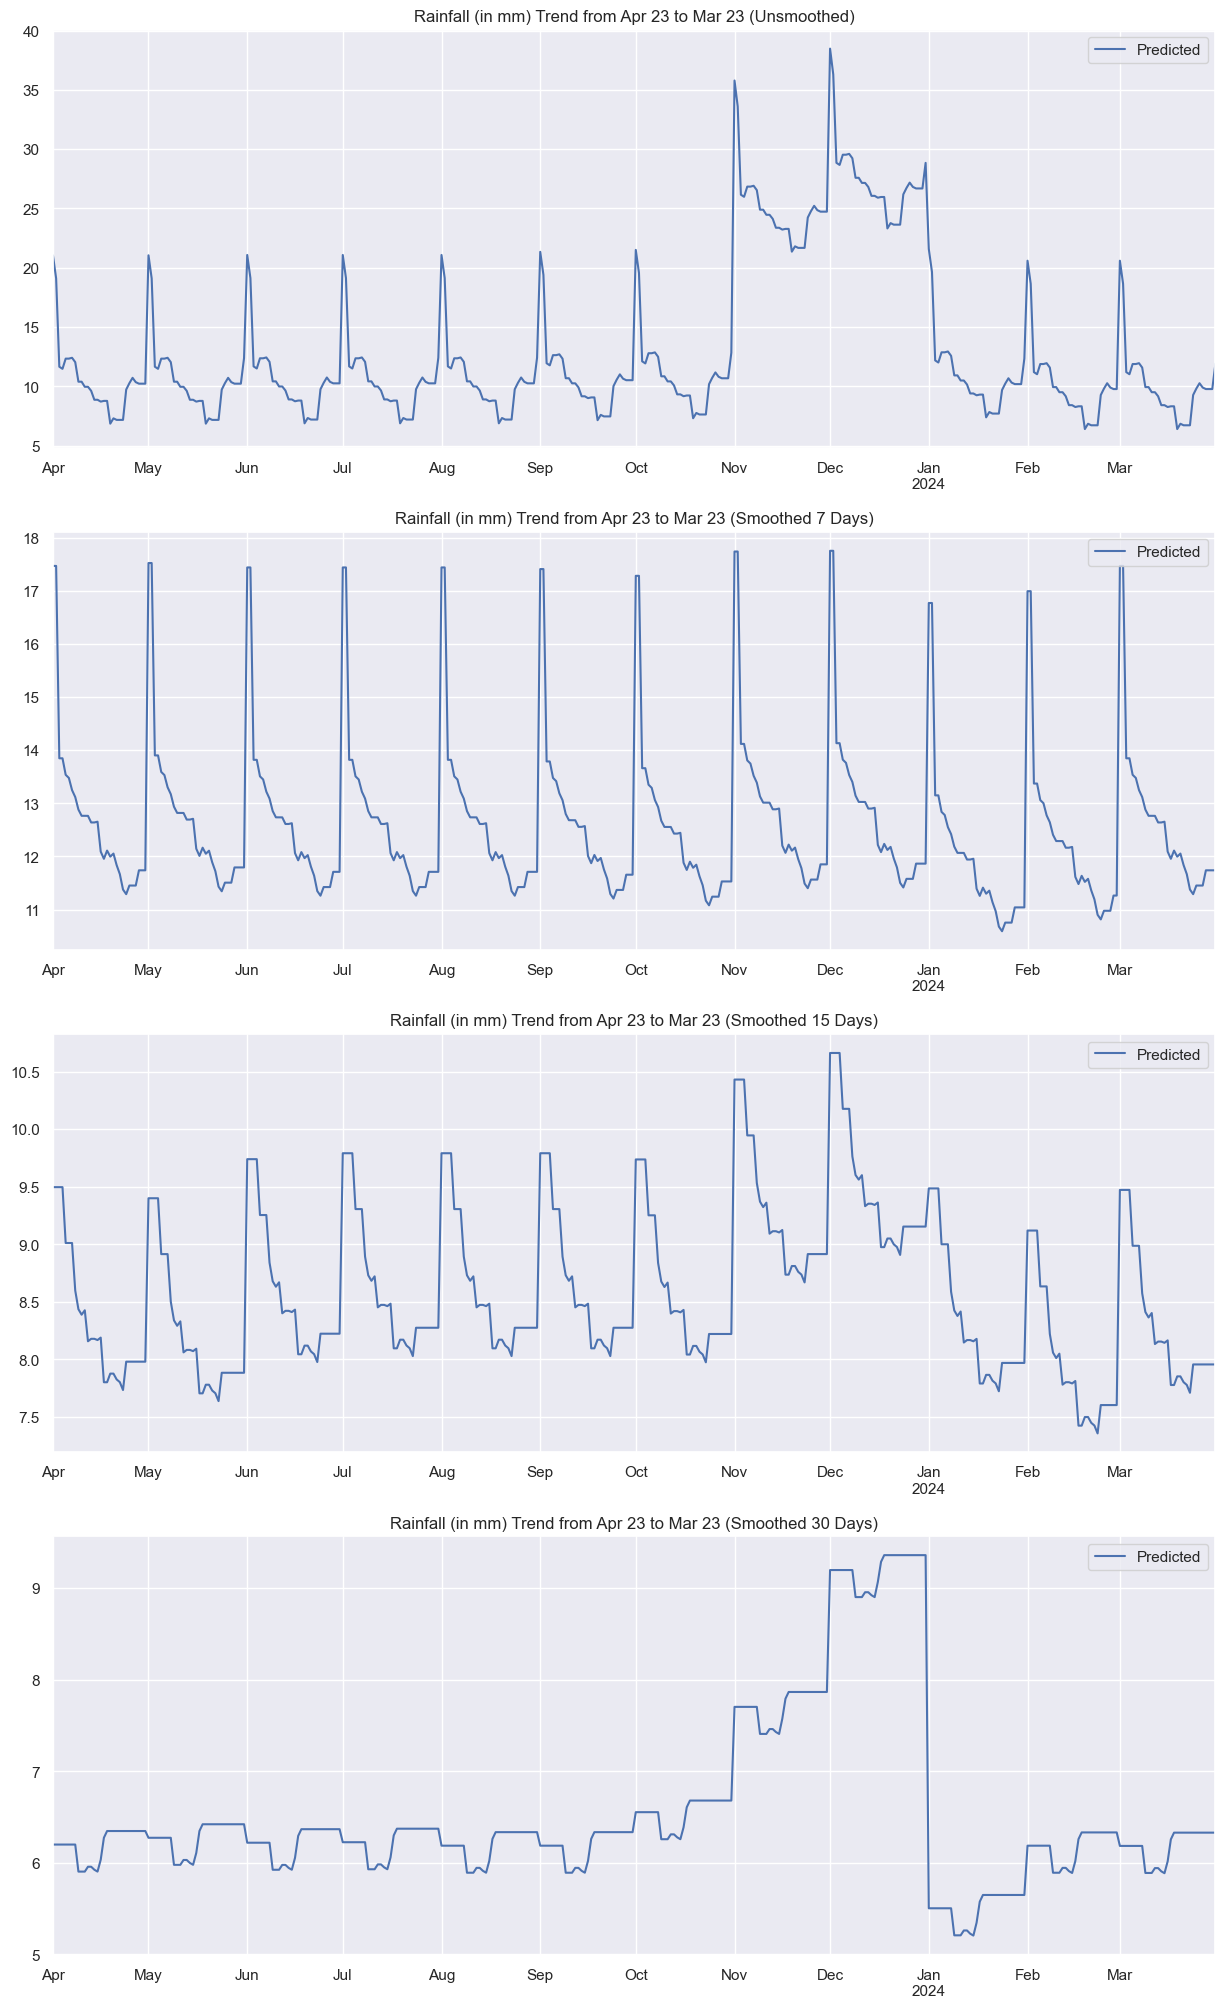

In [25]:
combinedFuture4 = rain_forecast(lagY7, rainData, reg_y7ns, '2023-04-01', '2024-03-31')
combinedFuture4s7 = rain_forecast(lagY7, mov_7, reg_y7s7, '2023-04-01', '2024-03-31')
combinedFuture4s15 = rain_forecast(lagY7, mov_15, reg_y7s15, '2023-04-01', '2024-03-31')
combinedFuture4s30 = rain_forecast(lagY7, mov_30, reg_y7s30, '2023-04-01', '2024-03-31')

f, axes = plt.subplots(4, 1, figsize=(15, 25))
combinedFuture4.plot(ax=axes[0], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Unsmoothed)')
combinedFuture4s7.plot(ax=axes[1], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 7 Days)')
combinedFuture4s15.plot(ax=axes[2], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 15 Days)')
combinedFuture4s30.plot(ax=axes[3], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 30 Days)')
plt.show()

The trend from the 30 day smoothed set seem slighly better compared to the one from M-9, but the rest seem to have not improved.

Recall that we have Temperature and Humidity as other predictors of rainfall. Let's add them and verify our model's performance.

In [26]:
lagTemp = lagY7 + ['D-1_temp','D-2_temp','D-3_temp',
                   'M-1_temp','M-2_temp','M-3_temp','M-4_temp','M-5_temp','M-6_temp','M-7_temp','M-8_temp','M-9_temp',
                   'Y-1_temp','Y-2_temp','Y-3_temp','Y-4_temp','Y-5_temp','Y-6_temp','Y-7_temp']

print("Temperature, Unsmoothed")
reg_tns = fold_training(lagTemp, rainData, rainData)
print()

print("Temperature, Smoothed 7 Days")
reg_ts7 = fold_training(lagTemp, mov_7, rainData)
print()

print("Temperature, Smoothed 15 Days")
reg_ts15 = fold_training(lagTemp, mov_15, rainData)
print()

print("Temperature, Smoothed 30 Days")
reg_ts30 = fold_training(lagTemp, mov_30, rainData)
print()

Temperature, Unsmoothed
Score across folds 13.60
Fold scores:[12.69, 11.99, 15.5, 14.18, 12.68, 12.91, 13.08, 15.28, 14.05]

Temperature, Smoothed 7 Days
Score across folds 11.96
Fold scores:[10.17, 10.37, 12.79, 11.21, 10.16, 11.81, 11.97, 14.98, 14.22]

Temperature, Smoothed 15 Days
Score across folds 11.57
Fold scores:[10.15, 10.22, 12.56, 10.76, 9.7, 11.74, 11.5, 14.04, 13.46]

Temperature, Smoothed 30 Days
Score across folds 11.19
Fold scores:[9.81, 9.83, 12.29, 10.55, 9.61, 11.38, 10.86, 13.35, 13.01]



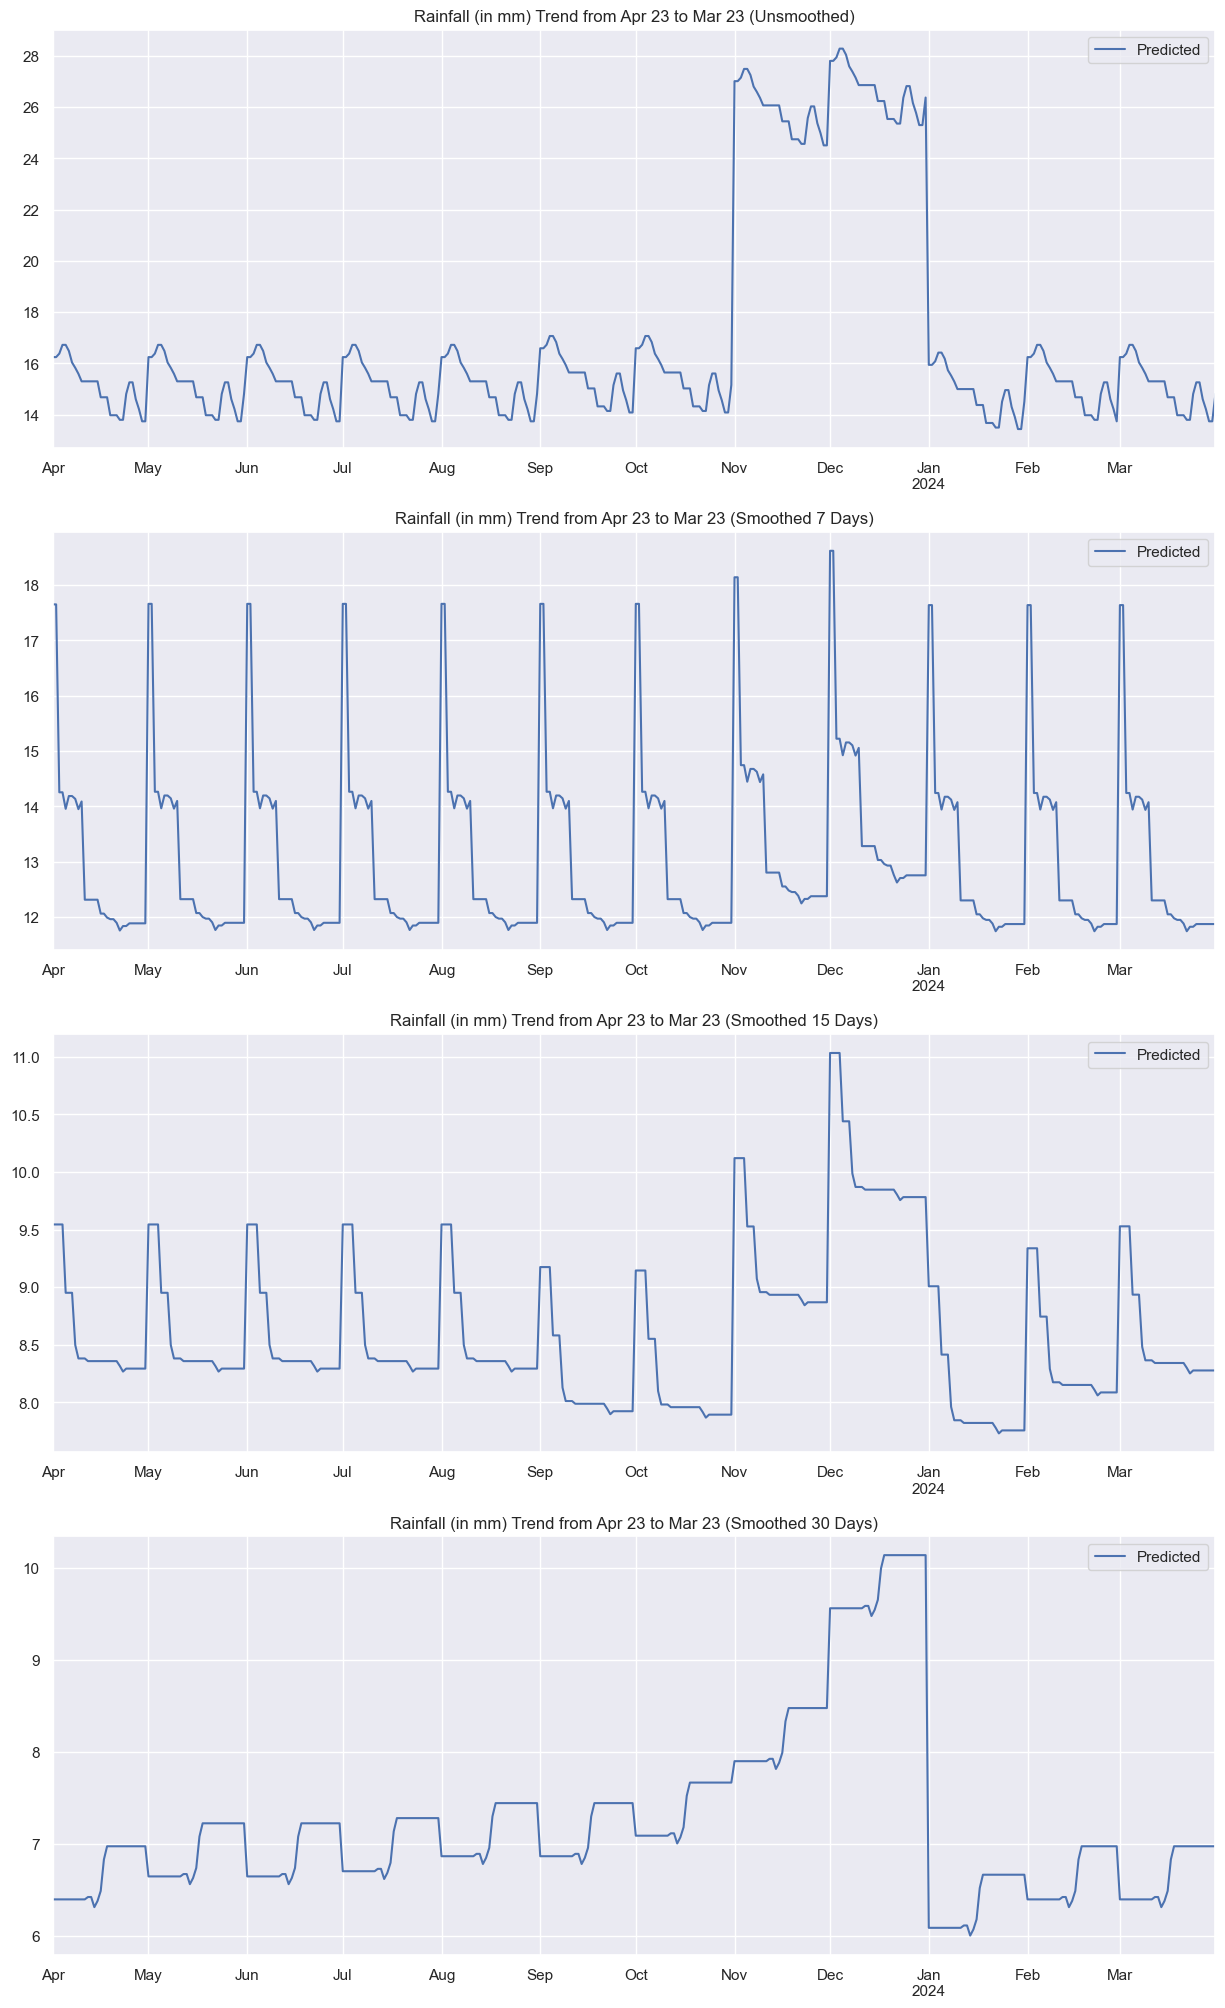

In [27]:
combinedFutureTemp = rain_forecast(lagTemp, rainData, reg_tns, '2023-04-01', '2024-03-31')
combinedFutureTemps7 = rain_forecast(lagTemp, mov_7, reg_ts7, '2023-04-01', '2024-03-31')
combinedFutureTemps15 = rain_forecast(lagTemp, mov_15, reg_ts15, '2023-04-01', '2024-03-31')
combinedFutureTemps30 = rain_forecast(lagTemp, mov_30, reg_ts30, '2023-04-01', '2024-03-31')

f, axes = plt.subplots(4, 1, figsize=(15, 25))
combinedFutureTemp.plot(ax=axes[0], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Unsmoothed)')
combinedFutureTemps7.plot(ax=axes[1], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 7 Days)')
combinedFutureTemps15.plot(ax=axes[2], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 15 Days)')
combinedFutureTemps30.plot(ax=axes[3], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 30 Days)')
plt.show()

Adding Temperature as a lag feature did not improve our performance. Also, both the smoothed and unsmoothed graphs seem to deviate slightly from that of Y-7. Let's see if adding humidity does.

In [28]:
hum = ['D-1_hum','D-2_hum','D-3_hum',
       'M-1_hum','M-2_hum','M-3_hum','M-4_hum','M-5_hum','M-6_hum','M-7_hum','M-8_hum','M-9_hum',
       'Y-1_hum','Y-2_hum','Y-3_hum','Y-4_hum','Y-5_hum','Y-6_hum','Y-7_hum']

lagHum = lagY7 + hum

print("Humidity, Unsmoothed")
reg_hns = fold_training(lagHum, rainData, rainData)
print()

print("Humidity, Smoothed 7 Days")
reg_hs7 = fold_training(lagHum, mov_7, rainData)
print()

print("Humidity, Smoothed 15 Days")
reg_hs15 = fold_training(lagHum, mov_15, rainData)
print()

print("Humidity, Smoothed 30 Days")
reg_hs30 = fold_training(lagHum, mov_30, rainData)
print()

Humidity, Unsmoothed
Score across folds 12.78
Fold scores:[11.93, 11.29, 14.44, 14.24, 11.18, 12.68, 11.26, 14.15, 13.81]

Humidity, Smoothed 7 Days
Score across folds 12.02
Fold scores:[10.22, 10.36, 12.7, 11.46, 9.91, 12.22, 12.34, 14.8, 14.19]

Humidity, Smoothed 15 Days
Score across folds 11.46
Fold scores:[9.95, 10.08, 12.37, 11.14, 9.6, 11.5, 11.2, 13.89, 13.37]

Humidity, Smoothed 30 Days
Score across folds 11.20
Fold scores:[9.79, 9.85, 12.23, 10.44, 9.63, 11.46, 11.01, 13.38, 13.05]



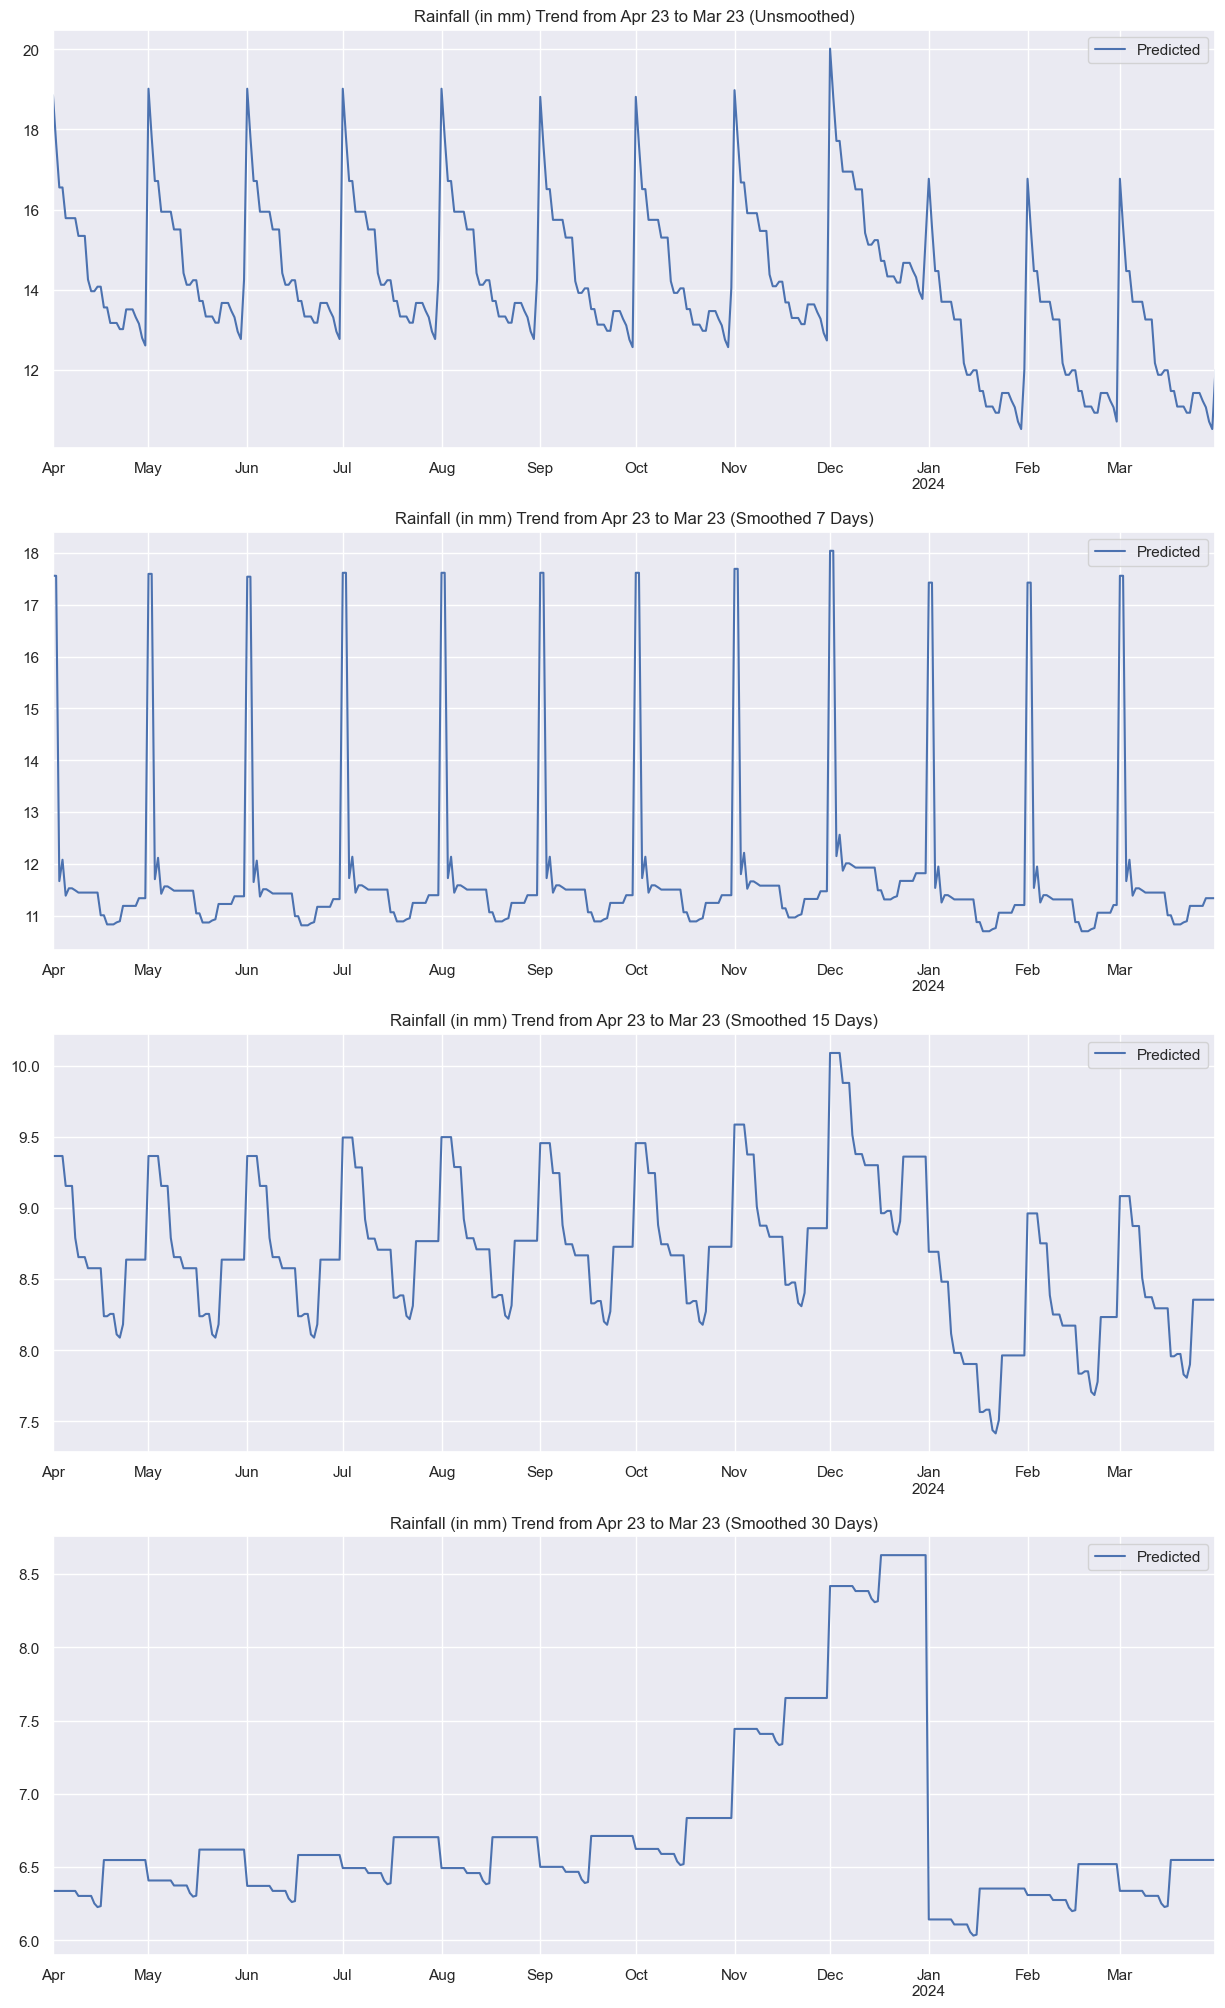

In [29]:
combinedFutureHum = rain_forecast(lagHum, rainData, reg_hns, '2023-04-01', '2024-03-31')
combinedFutureHums7 = rain_forecast(lagHum, mov_7, reg_hs7, '2023-04-01', '2024-03-31')
combinedFutureHums15 = rain_forecast(lagHum, mov_15, reg_hs15, '2023-04-01', '2024-03-31')
combinedFutureHums30 = rain_forecast(lagHum, mov_30, reg_hs30, '2023-04-01', '2024-03-31')

f, axes = plt.subplots(4, 1, figsize=(15, 25))
combinedFutureHum.plot(ax=axes[0], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Unsmoothed)')
combinedFutureHums7.plot(ax=axes[1], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 7 Days)')
combinedFutureHums15.plot(ax=axes[2], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 15 Days)')
combinedFutureHums30.plot(ax=axes[3], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 30 Days)')
plt.show()

Adding Humidity did not improve our performance either. Let's see if adding both Temperature & Humidity does.

In [30]:
lagTempHum = lagTemp + hum

print("Humidity & Temperature, Unsmoothed")
reg_thns = fold_training(lagTempHum, rainData, rainData)
print()

print("Humidity & Temperature, Smoothed 7 Days")
reg_ths7 = fold_training(lagTempHum, mov_7, rainData)
print()

print("Humidity & Temperature, Smoothed 15 Days")
reg_ths15 = fold_training(lagTempHum, mov_15, rainData)
print()

print("Humidity & Temperature, Smoothed 30 Days")
reg_ths30 = fold_training(lagTempHum, mov_30, rainData)
print()

Humidity & Temperature, Unsmoothed
Score across folds 12.96
Fold scores:[12.57, 11.39, 14.81, 14.41, 12.13, 12.66, 11.08, 14.24, 13.31]

Humidity & Temperature, Smoothed 7 Days
Score across folds 11.96
Fold scores:[10.29, 10.31, 12.51, 11.32, 10.16, 11.96, 12.08, 14.86, 14.15]

Humidity & Temperature, Smoothed 15 Days
Score across folds 11.47
Fold scores:[9.95, 10.09, 12.55, 10.83, 9.71, 11.65, 11.22, 13.95, 13.32]

Humidity & Temperature, Smoothed 30 Days
Score across folds 11.20
Fold scores:[9.71, 9.85, 12.33, 10.54, 9.55, 11.43, 11.06, 13.35, 12.99]



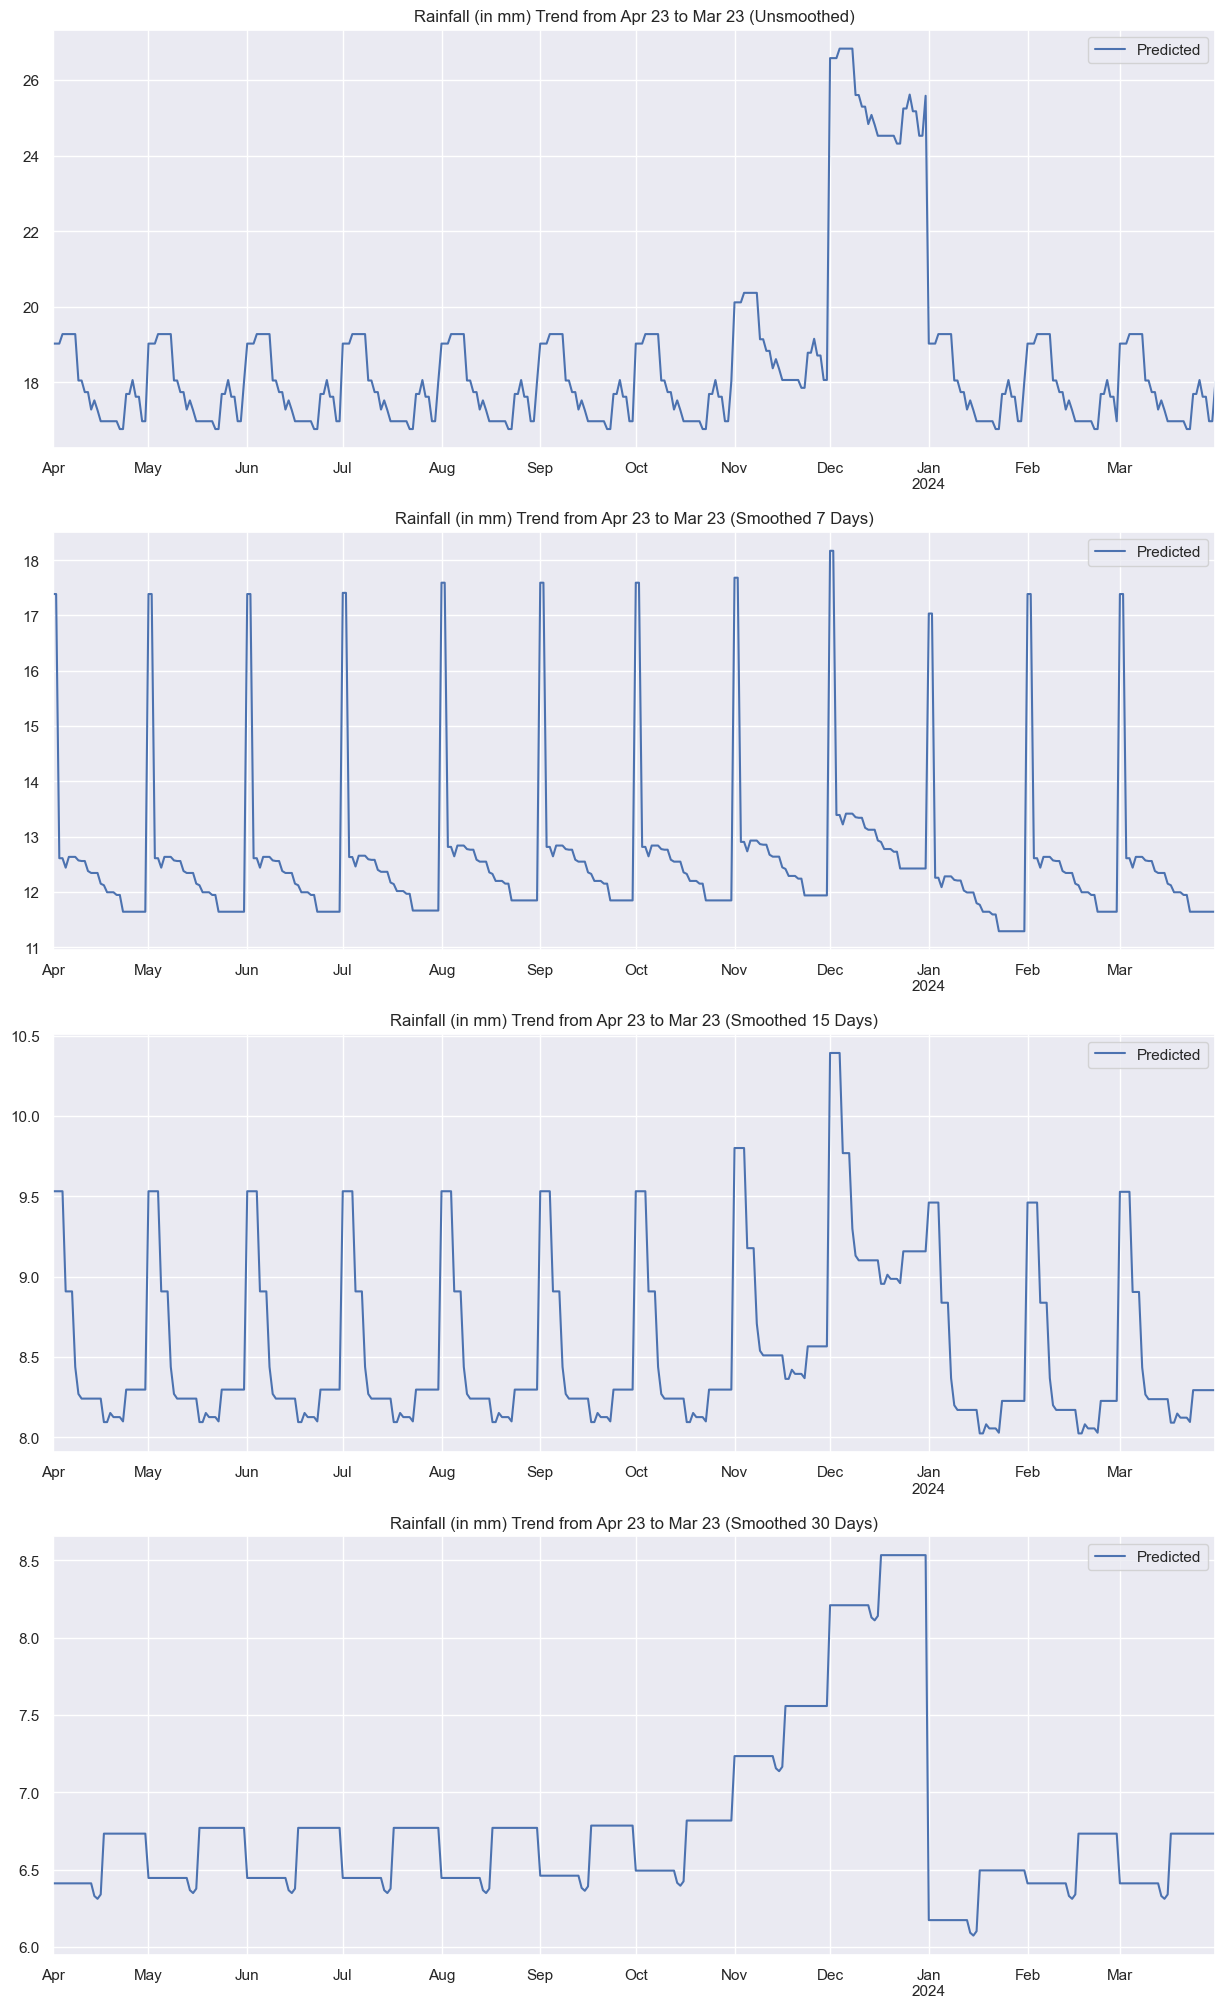

In [31]:
combinedFutureTempHum = rain_forecast(lagTempHum, rainData, reg_thns, '2023-04-01', '2024-03-31')
combinedFutureTempHums7 = rain_forecast(lagTempHum, mov_7, reg_ths7, '2023-04-01', '2024-03-31')
combinedFutureTempHums15 = rain_forecast(lagTempHum, mov_15, reg_ths15, '2023-04-01', '2024-03-31')
combinedFutureTempHums30 = rain_forecast(lagTempHum, mov_30, reg_ths30, '2023-04-01', '2024-03-31')

f, axes = plt.subplots(4, 1, figsize=(15, 25))
combinedFutureTempHum.plot(ax=axes[0], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Unsmoothed)')
combinedFutureTempHums7.plot(ax=axes[1], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 7 Days)')
combinedFutureTempHums15.plot(ax=axes[2], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 15 Days)')
combinedFutureTempHums30.plot(ax=axes[3], y='Predicted', title='Rainfall (in mm) Trend from Apr 23 to Mar 23 (Smoothed 30 Days)')
plt.show()

Turns out that adding either Temperature & Humidity does not improve our model's performance. We'll only use time for our prediction from now on.

Note that in all our predictions, the performance of the 30 day smoothed sets tend to outperform their other counterparts, as indicated by their RMSE and the shape of their 1 year prediction graph. We concluded that smoothing our train dataset over 30 days gives us the best prediction, as it removes all fluctuations that may affect our prediction within the month.

Back to our problem motivation, we want to input these daily predicted values into our smart water sprinkler system. We've created a hypothetical smart water sprinkler system that has the following inputs and outputs.

Inputs
- Crop's irrigation requirements (From Human Input)
- Predicted daily rainfall for 1 year (From our Machine Learning Model)

Outputs
- Residual water requirements adjusted for predicted rainfall.

Let's input the predicted daily rainfall into the smart sprinkler system and ask our fella agriculturer for his/her crop's irrigation requirements:

Input Crop's Daily Watering Requirement (in mm): 10


C:\Users\SQ\AppData\Local\Temp\ipykernel_22796\4009365789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_req['Predicted'] = float(water) - water_req['Predicted']
C:\Users\SQ\AppData\Local\Temp\ipykernel_22796\4009365789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_req[water_req['Predicted'] <= 0] = 0


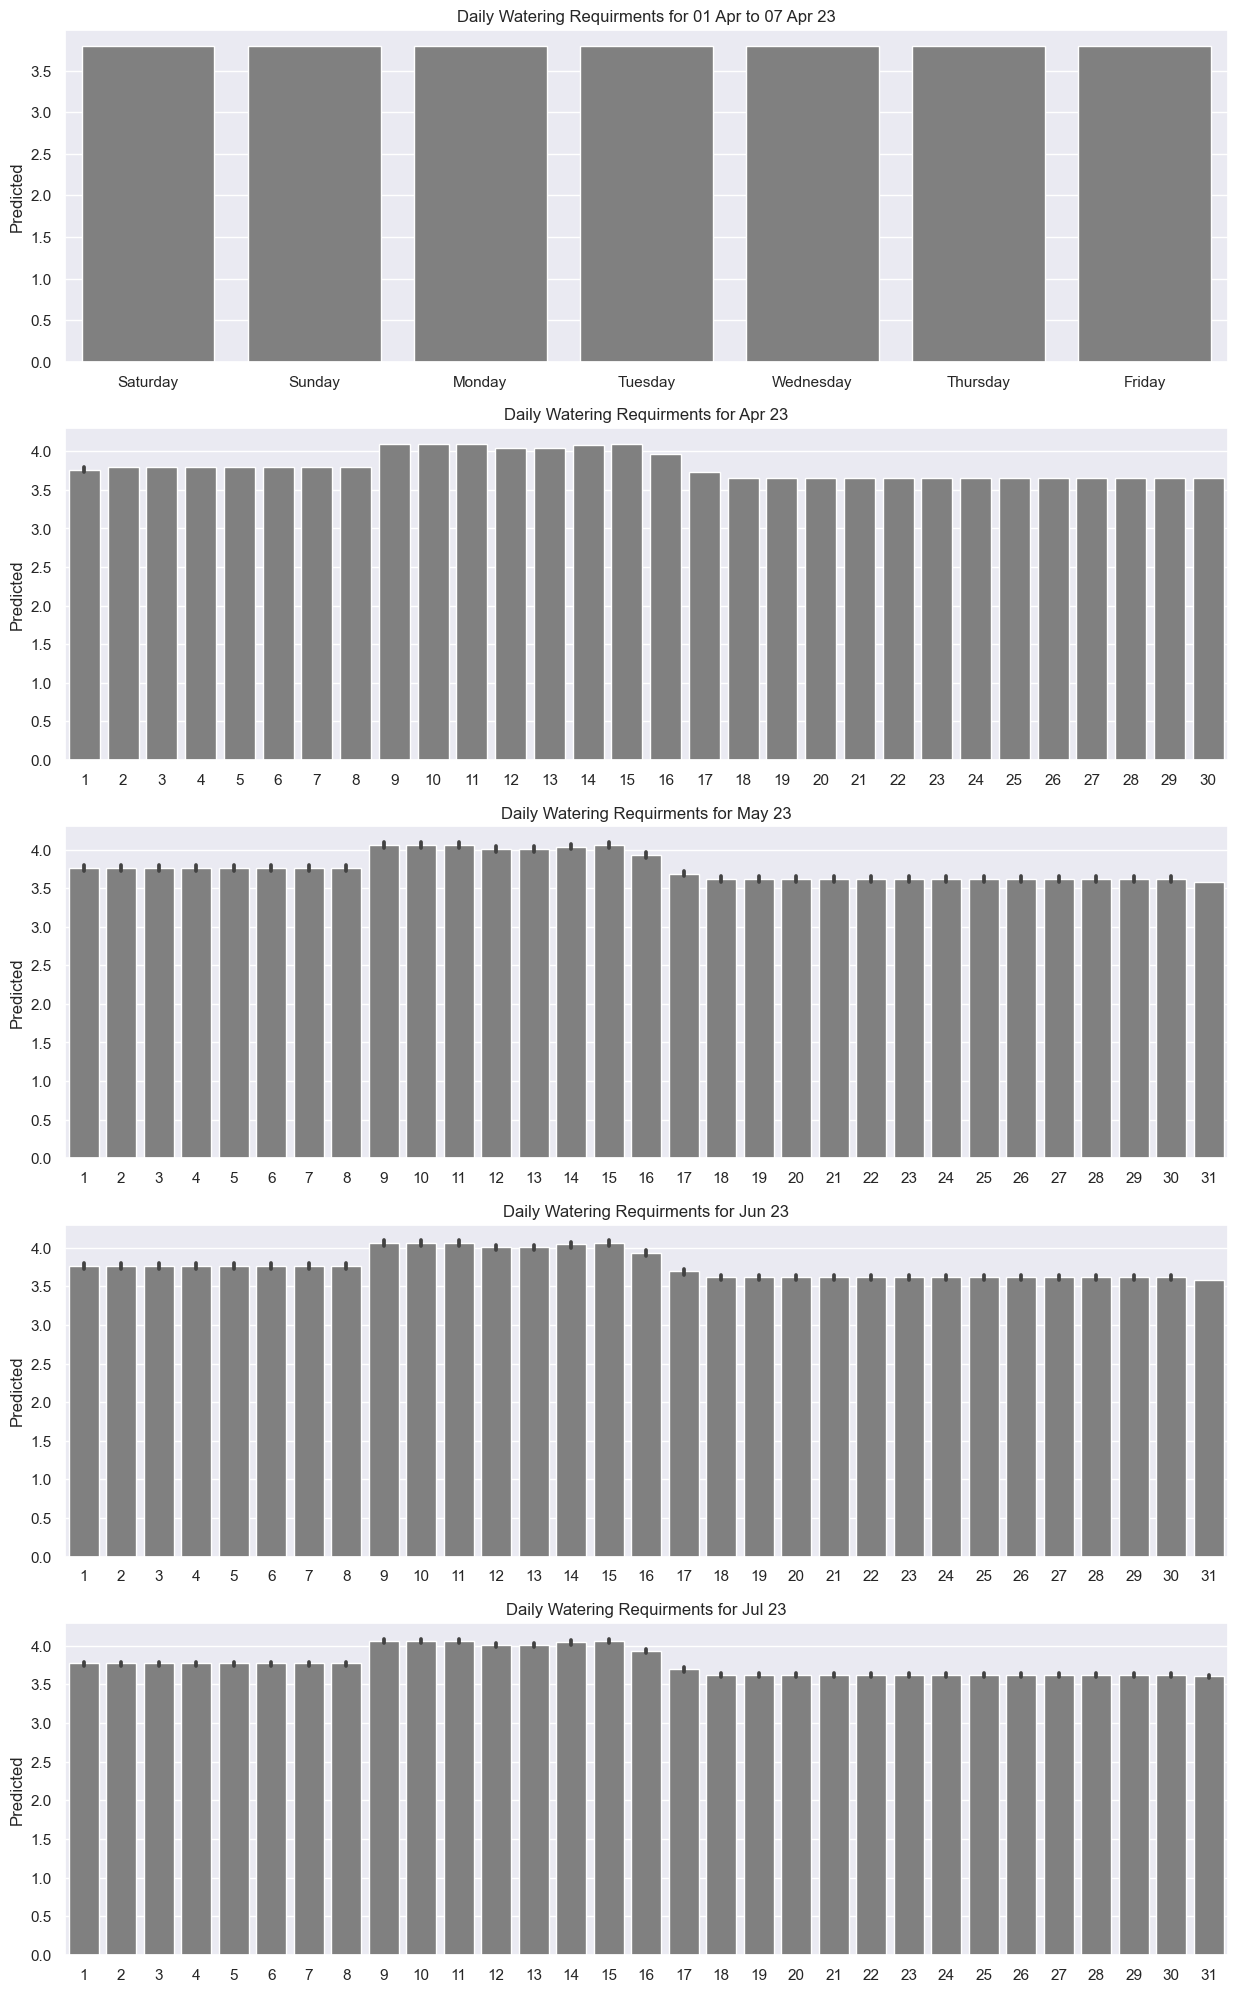

In [32]:
water = input("Input Crop's Daily Watering Requirement (in mm): ")

water_req = combinedFuture4s30[['Year','Month','Day','Predicted']]
water_req['Predicted'] = float(water) - water_req['Predicted'] 
water_req[water_req['Predicted'] <= 0] = 0

oneWk = water_req[water_req.index <= '2023-04-07']
oneMth = water_req[water_req.index <= '2023-05-01']
May23 = water_req[water_req.index <= '2023-05-31']
Jun23 = water_req[water_req.index <= '2023-06-30']
Jul23 = water_req[water_req.index <= '2023-07-31']

f, axes = plt.subplots(5, 1, figsize=(15, 25))

sb.barplot(ax=axes[0], data=oneWk, x=oneWk.index.day_name(), y='Predicted', color='Grey').set_title('Daily Watering Requirments for 01 Apr to 07 Apr 23')
sb.barplot(ax=axes[1], data=oneMth, x=oneMth.index.day, y='Predicted', color='Grey').set_title('Daily Watering Requirments for Apr 23')
sb.barplot(ax=axes[2], data=May23, x=May23.index.day, y='Predicted', color='Grey').set_title('Daily Watering Requirments for May 23')
sb.barplot(ax=axes[3], data=Jun23, x=Jun23.index.day, y='Predicted', color='Grey').set_title('Daily Watering Requirments for Jun 23')
sb.barplot(ax=axes[4], data=Jul23, x=Jul23.index.day, y='Predicted', color='Grey').set_title('Daily Watering Requirments for Jul 23')

plt.show()

From the bar charts, we see that the daily watering requirements for:
- 1st week of Apr: ~3.8mm
- Apr 23: ~3.7mm to ~4.2mm (more water required between 9th to 16th day of the Month)
- May 23 to Jul 23: Similar to Apr 23

Note that this assumes that there will be rain everyday, which may not be true. We need more predictors to tell the probability of rain happening, such as cloud buildups and wind movements. However, that would become weather prediction which is out of the scope of our project.

Look at how much water we save by irrigation, by using data from predicted rainfall amount to optimise our smart sprinkler systems!

# Summary
In summary, we did the following for machine learning.

Using Train/Test Split, we spliced our data into 9 folds, each contain train dataset of increasing time interval from the previous fold, and a test dataset of a fixed time interval (1 year). Each fold then trains the test set of the previous fold to learn the dataset's dependence of past observations, which helps us predict into the future. 9 fold was decided as it gave us the best model performance (RMSE) and most consistent performance across the folds. 

Our initial training with the raw dataset gave us a RMSE of 12.08. As the daily rainfall amount fluctuates drastically without an obvious trend, we thought that doing a moving average to smooth out these fluctuations in our training set could make our training more consistent and prediction accurate. We retrained the dataset that has been smoothed over 7, 15 and 30 days and obtained a RMSEs of 11.35 for the 30 days smoothed set. We then did 4 versions (Unsmoothed, 7 days smoothed, 15 days smoothed and 30 days smoothed sets) of subsequent trainings and predictions to confirm our theory. It turned out that smoothing over 30 days gave us the most accurate prediction, as it removes all fluctuations within the month that affects our machine learning.

When we forecast the rainfall for 1 year, the seasonal trend of both graphs are erratic and are nothing alike to the one from our EDA. We realised that as our rainfall data has an annual seasonal pattern, we need to use past copies of data (lagged features) in our training to capture this pattern. Adding lagged features of different time deltas (difference) improved our model's performance, and our forecast began showing a seasonal trend close to the one we expect. We optimised the model by trying out different time deltas, and derived that using lagged features from the past 3 days, 9 months and 7 years gave us the best performance, with a RMSE of 11.13.

From our EDA section, we noticed that Temperature and Humidity has a Negative and Positive relationship with rainfall amount respectively. We trained and predicted using these variables, but discovered that they did not improve our performance. Our graphs also began to deviate from the ideal pattern. Therefore, we've decided to only use Time to predict future values.

Back to our problem motivation, we created a hypothetical smart water sprinkler system that takes 1) crop's daily irrigation requirements and 2) rainfall prediction as inputs and outputs the estimated water requirements to supplement natural irrigation by rainfall.

# References

Rob M. (2022) PT2: Time Series Forecasting with XGBoost
https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost

Ryan H.(Year Unknown) Trend
https://www.kaggle.com/code/ryanholbrook/trend

Ryan H.(Year Unknown) Time Series as Features
https://www.kaggle.com/code/ryanholbrook/time-series-as-features
